# Проект: Обучение с учителем: качество модели

**Цель:**  разработать эффективную систему персонализированных предложений постоянным клиентам интернет-магазина, чтобы увеличить их покупательскую активность.

**Задачи:**
1. Проанализировать текущую базу данных постоянных клиентов интернет-магазина

2. Собрать и систематизировать данные по четырём ключевым группам признаков:
* коммуникация с клиентом
* продуктовое поведение покупателя
* финансовое поведение клиента
* поведение покупателя на сайте
  
3. Разработать модель, способную предсказывать вероятность снижения покупательской активности в ближайшие 3 месяца
4. Интегрировать дополнительные данные о прибыльности клиентов из финансового департамента
5. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения 

**План работы:**
* Загрузка данных 
* Предобработка данных
* Исследовательский анализ данных
* Объединение таблиц
* Корреляционный анализ
* Использование пайплайнов
* Анализ важности данных
* Сегментация данных
* Общие выводы

## Загрузка данных

Импортируем необходимые для дальнейшей работы библиотеки

In [1]:
!pip install phik -q
!pip install shap -q
!pip install -U scikit-learn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import shap
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor  
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder 
from sklearn.dummy import DummyClassifier

In [3]:
try:
    df_main = pd.read_csv('/datasets/market_main.csv', sep=',')
    df_money = pd.read_csv('/datasets/market_money.csv', sep=',')
    df_time = pd.read_csv('/datasets/market_time.csv', sep=',')
    df_profit = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')
except:
    df_main = pd.read_csv('https://code.s3.yandex.net//datasets/market_file.csv', sep=',')
    df_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv', sep=',')
    df_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv', sep=',')
    df_profit = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')

In [4]:
# общая информация и первые 5 строк первого датафрейма 
print(df_main.info())
df_main.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


Первая таблица состоит из 1300 строк и 13 столбцов и содержит информацию о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении. Пропущенных значений нет, типы данных корректны. Однако, названия столбцов, даже при использовании кириллицы, недостаточно удобны для работы, поэтому в дальнейшем часть их них мы скорректируем.  

In [5]:
# общая информация и первые 5 строк второго датафрейма 
print(df_money.info())
df_money.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
None


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


Вторая таблица содержит 3900 строк и 3 столбца. Здесь представленны данные о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. Пропущенных значений нет, типы данных корректны. 

По первым строкам таблицы можно предварительно сделать вывод, что информация о ежемесячной выручке представлена за три последних месяца. В дальнейшем это надо проверить. 

In [6]:
# общая информация и первые 5 строк третьего датафрейма 
print(df_time.info())
df_time.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
None


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


Вторая таблица содержит 2600 строк и 3 столбца. Здесь представленны данные о времени (в минутах), которое покупатель провёл на сайте в течение периода. Пропущенных значений нет, типы данных корректны. 
По первым строкам таблицы можно предварительно сделать вывод, что информация по каждому покупателю представлена за 2 последних месяца. В дальнейшем это надо проверить. В данных также видны опечатки, их нужно будет исправить.

In [7]:
# общая информация и первые 5 строк четвертого датафрейма 
print(df_profit.info())
df_profit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB
None


,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


В последней таблице представлена информация о том, какую прибыль получает магазин от продаж каждому покупателю. В таблице 1300 строк и 2 столбца. Пропущенных значений нет, во втором столбце неккоректный тип данных. 

**Вывод:** Загрузили 4 таблицы, проверили корректность данных и их соотвествию описанию. В результате были обнаружены следующие проблемы: неудобные названия столбцов, опечатки и некорректный тип данных в одной из таблиц. Необходимо провести предобработку данных. 

## Предобработка данных 

### Изменение названий столбцов

Изменим названия столбцов на более удобные в дальнейшем использовании, при этом оставим кириллические названия. Постараемся чтобы названия были краткими, но емкими, а также пристуствовало единообразие в записи  

In [8]:
df_main = df_main.rename(columns = {'Покупательская активность':'активность', 'Тип сервиса':'уровень', 'Разрешить сообщать':'рассылки', \
                                    'Маркет_актив_6_мес':'маркетинг_6_мес', 'Маркет_актив_тек_мес':'маркетинг_текущ', 'Длительность':'длительность', \
                                    'Акционные_покупки':'доля_акционных', 'Популярная_категория':'топ-категория', \
                                    'Средний_просмотр_категорий_за_визит':'категорий/визит', \
                                    'Неоплаченные_продукты_штук_квартал':'неопл_товары', 'Ошибка_сервиса':'сбои', 'Страниц_за_визит':'страниц/визит'})

df_main.head()

,id,активность,уровень,рассылки,маркетинг_6_мес,маркетинг_текущ,длительность,доля_акционных,топ-категория,категорий/визит,неопл_товары,сбои,страниц/визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [9]:
df_money = df_money.rename(columns = {'Период':'период', 'Выручка':'выручка'})
df_money.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [10]:
df_time = df_time.rename(columns = {'Период':'период', 'минут':'общее_время'})
df_time.head()

,id,период,общее_время
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [11]:
df_profit = df_profit.rename(columns = {'Прибыль':'средняя_прибыль'})
df_profit.head()

,id,средняя_прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


### Обработка пропущенных значений

Мы уже видели, что в таблицах не было нулевых значений. Убедимся в это еще раз 

In [12]:
# выведем суммарное количество пропусков 
print(f'В первом датафрейме {df_main.isna().sum().sum()} пропусков')
print(f'Во втором датафрейме {df_money.isna().sum().sum()} пропусков')
print(f'В третьем датафрейме {df_time.isna().sum().sum()} пропусков')
print(f'В четвертом датафрейме {df_profit.isna().sum().sum()} пропусков')

В первом датафрейме 0 пропусков
Во втором датафрейме 0 пропусков
В третьем датафрейме 0 пропусков
В четвертом датафрейме 0 пропусков


### Обработка дубликатов

In [13]:
# выведем суммарное количество явных дубликатов 
print(f'В первом датафрейме {df_main.duplicated().sum()} дубликатов') 
print(f'Во втором датафрейме {df_money.duplicated().sum()} дубликатов')
print(f'В третьем датафрейме {df_time.duplicated().sum()} дубликатов')
print(f'В четвертом датафрейме {df_profit.duplicated().sum()} дубликатов')

В первом датафрейме 0 дубликатов
Во втором датафрейме 0 дубликатов
В третьем датафрейме 0 дубликатов
В четвертом датафрейме 0 дубликатов


Явных дубликатов нет. Выведем уникальные значения для всех категориальных столбцов первой таблицы

In [14]:
main_cat_cols = ['активность', 'уровень', 'рассылки', 'топ-категория']
for col in main_cat_cols:
    print(f'В столбце "{col}" следующие уникальные значения: {df_main[col].unique()}')

В столбце "активность" следующие уникальные значения: ['Снизилась' 'Прежний уровень']
В столбце "уровень" следующие уникальные значения: ['премиум' 'стандартт' 'стандарт']
В столбце "рассылки" следующие уникальные значения: ['да' 'нет']
В столбце "топ-категория" следующие уникальные значения: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


Неявные дубликаты есть только в столбце *"уровень"*, исправим это. Также приведем данные к единообразному виду и избавимся от опечаток.

In [15]:
df_main['активность'] = df_main['активность'].str.replace('Прежний уровень', 'прежняя')
df_main['уровень'] = df_main['уровень'].str.replace('стандартт', 'стандарт')
df_main['топ-категория'] = df_main['топ-категория'].str.replace('Косметика и аксесуары', 'косметика и аксессуары')

In [16]:
print('После преобразований в датафрейме df_main:')
for col in main_cat_cols:
    df_main[col] = df_main[col].str.lower()
    print(f'В столбце "{col}" следующие уникальные значения: {df_main[col].unique()}')

После преобразований в датафрейме df_main:
В столбце "активность" следующие уникальные значения: ['снизилась' 'прежняя']
В столбце "уровень" следующие уникальные значения: ['премиум' 'стандарт']
В столбце "рассылки" следующие уникальные значения: ['да' 'нет']
В столбце "топ-категория" следующие уникальные значения: ['товары для детей' 'домашний текстиль' 'косметика и аксессуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']


In [17]:
#первый датафрейм после изменений
df_main.head()

,id,активность,уровень,рассылки,маркетинг_6_мес,маркетинг_текущ,длительность,доля_акционных,топ-категория,категорий/визит,неопл_товары,сбои,страниц/визит
0,215348,снизилась,премиум,да,3.4,5,121,0.00,товары для детей,6,2,1,5
1,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5
2,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5
3,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4
4,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2


Теперь рассмотрим уникальные значения во втором датафрейме. Здесь только один категориальный столбец. 

In [18]:
print(df_money['период'].unique())

['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


Как и предпологалось раннее во второй таблице хранится информация за три периода времени. 

Рассмотрим третью таблицу.

In [19]:
df_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Исправим опечатку

In [20]:
df_time['период'] = df_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')

В третьем датафрейме содержится информация за два периода.

In [21]:
#третий датафрейм после изменений
df_time.head()

,id,период,общее_время
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


### Изменение типов данных

В четвертом датафрейме нет категориальных столбцов, зато есть неверный тип данных

In [22]:
df_profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               1300 non-null   int64 
 1   средняя_прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


Изменим тип данных в столбце *"средняя_прибыль"* на *float*

In [23]:
df_profit['средняя_прибыль'] = df_profit['средняя_прибыль'].str.replace(',', '.')
df_profit['средняя_прибыль'] = df_profit['средняя_прибыль'].astype(float)
df_profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1300 non-null   int64  
 1   средняя_прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Выводы**: Провели предобработку данных
* Изменили некоторые названия столбцов на более удобные, при этом оставив кириллицу 
* Убедились в отсутствии пропусков и явных дубликатов
* Избавились от неявных дубликатов
* Избавились от опечаток, привели категориальные данные к единообразной записи
* Изменили типы данных там, где это было необходимо

## Исследовательский анализ данных

### Первый датафрейм

Сначала посмотрим распределения категориальных признаков

активность
прежняя      802
снизилась    498
Name: id, dtype: int64


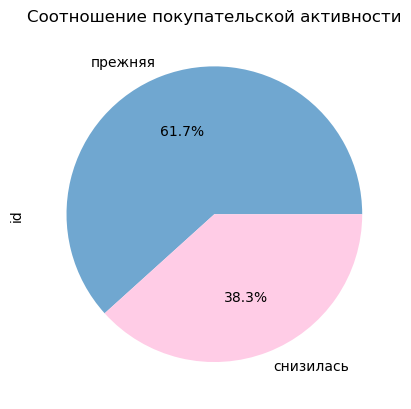

In [24]:
print(df_main.groupby('активность')['id'].count())
df_main.groupby('активность')['id'].count().plot(kind='pie', colors=['#70a7d0','#ffcce6'], autopct='%1.1f%%')
plt.title('Соотношение покупательской активности')
plt.show()

У 802 пользователей из 1300 (61.7 процентов) покупательская активность осталась на прежнем уровне. А у 498 человек (38.3 процентов) - снизилась, это довольно высокий показатель, подтверждающий начальное утверждение о снижении активности.

уровень
премиум     376
стандарт    924
Name: id, dtype: int64


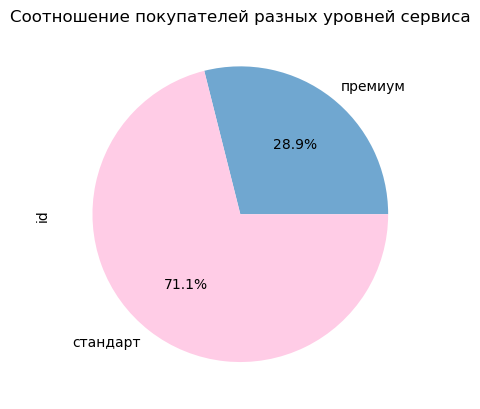

In [25]:
print(df_main.groupby('уровень')['id'].count())
df_main.groupby('уровень')['id'].count().plot(kind='pie', colors=['#70a7d0','#ffcce6'], autopct='%1.1f%%')
plt.title('Соотношение покупателей разных уровней сервиса')
plt.show()

Большинство покупателей относятся к стандартному уровню сервиса (71.1 процент), т.е. не имеют подписки, премиальных клиентов почти в 2,5 раза меньше.

рассылки
да     962
нет    338
Name: id, dtype: int64


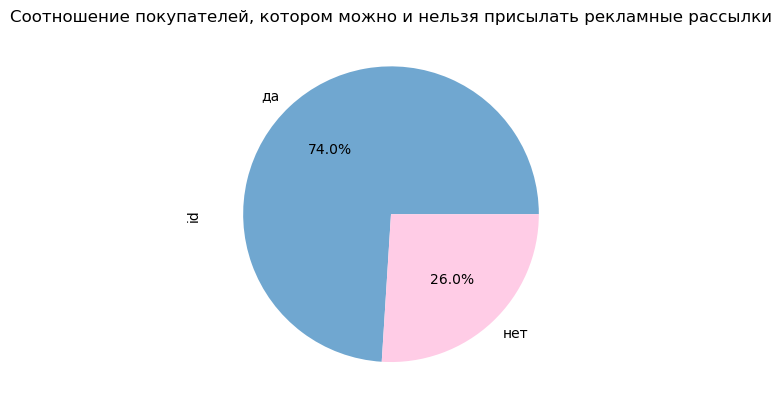

In [26]:
print(df_main.groupby('рассылки')['id'].count())
df_main.groupby('рассылки')['id'].count().plot(kind='pie', colors=['#70a7d0','#ffcce6'], autopct='%1.1f%%')
plt.title('Соотношение покупателей, котором можно и нельзя присылать рекламные рассылки')
plt.show()

Большинство покупателей согласились на рекламные рассылки, только 26 процентов пользователей не получают рекламные предложения

топ-категория
домашний текстиль                       251
косметика и аксессуары                  223
кухонная посуда                         138
мелкая бытовая техника и электроника    174
техника для красоты и здоровья          184
товары для детей                        330
Name: id, dtype: int64


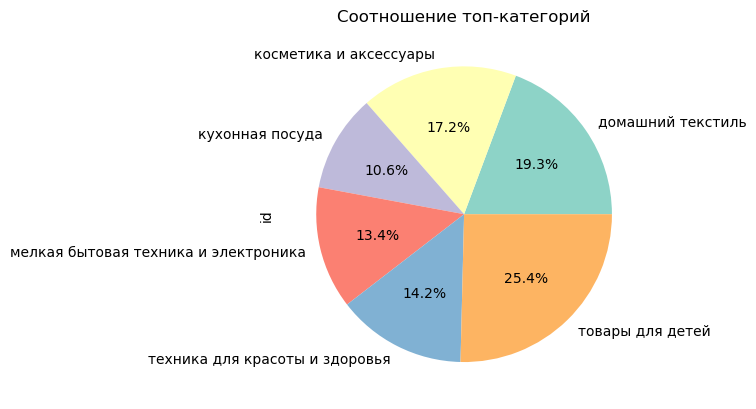

In [27]:
print(df_main.groupby('топ-категория')['id'].count())
# используем палитру Set3
colors = plt.cm.Set3(range(6))
df_main.groupby('топ-категория')['id'].count().plot(kind='pie', colors=colors, autopct='%1.1f%%')
plt.title('Соотношение топ-категорий')
plt.show()

Около четверти клиентов выбрали в качестве любимой категории товары для детей, около 19 процентов - домашний текстиль, 17 процентов - косметику и аксессуары. Технику для красоты и мелкую бытовую технику выбирают примерно одинаковое количество клиентов (14.2 и 13.4 процентов соответсвенно). Наименее популярная категория "кухонная посуда", ее выбрало менее 11 процентов покупателей. 

Перейдем к анализу количественных признаков. Построим для каждого признаками гистограмму и диаграмму размаха. 

In [28]:
# выведем описание
df_main.describe().round(2)

,id,маркетинг_6_мес,маркетинг_текущ,длительность,доля_акционных,категорий/визит,неопл_товары,сбои,страниц/визит
count,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00,1300.00
mean,215997.50,4.25,4.01,601.90,0.32,3.27,2.84,4.19,8.18
std,375.42,1.01,0.70,249.86,0.25,1.36,1.97,1.96,3.98
min,215348.00,0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00
25%,215672.75,3.70,4.00,405.50,0.17,2.00,1.00,3.00,5.00
50%,215997.50,4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00
75%,216322.25,4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00
max,216647.00,6.60,5.00,1079.00,0.99,6.00,10.00,9.00,20.00


In [29]:
#функция для построения гистограммы и диаграммы размаха для количественных признаков
def hist_and_boxplot(x, df, bins):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1) 
    sns.histplot(data=df, x=x, bins=bins, kde=True)
    plt.title('Гистограмма')
    plt.subplot(1, 2, 2) 
    df.boxplot(column=x)
    plt.title('Диаграмма размаха')
    plt.suptitle(x, fontsize=15)
    plt.show()

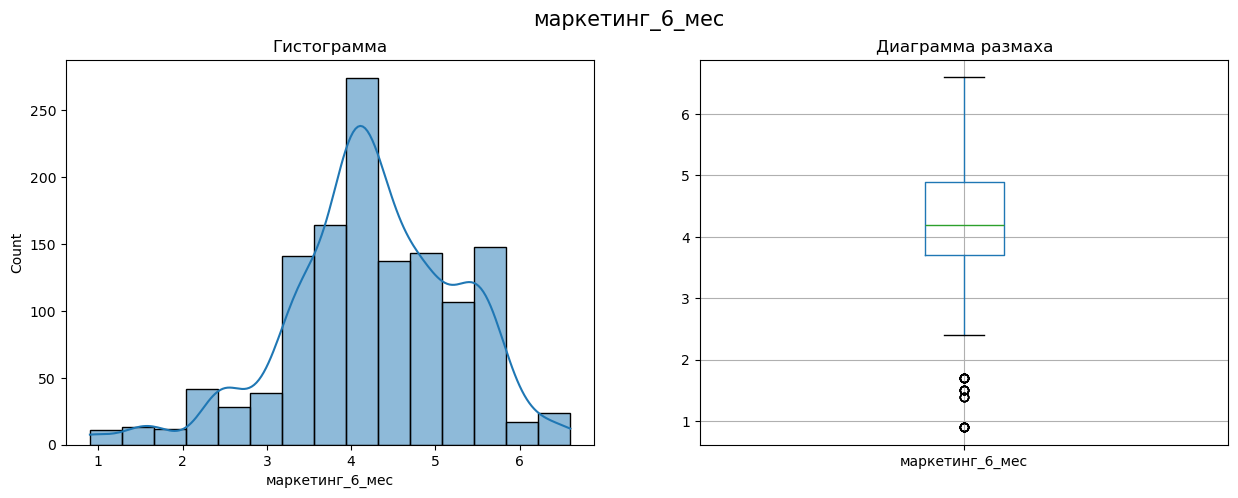

In [30]:
hist_and_boxplot('маркетинг_6_мес', df_main, 15)

Видно, что в среднем за 6 месяцев на одного покупателя приходилось около 4 рекламных рассылок/звонков/показов рекламы ежемесячно. При этом наблюдаются выбросы - есть клиенты, получившие менее 2 рекламных предложений. Эти данные оставим без изменения, это могут быть клиенты, не согласившиеся на рекламную рассылку, сократив тем самым количество маркетинговых коммуникаций.       

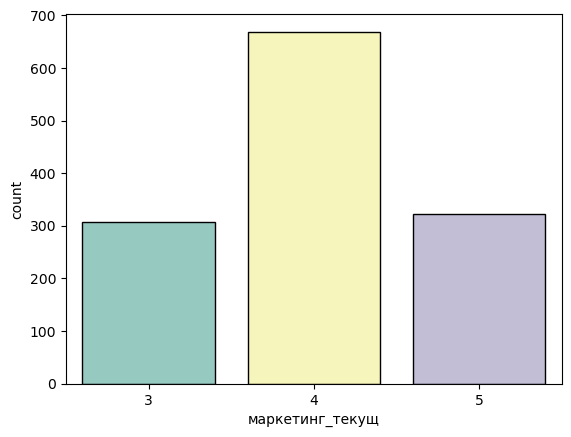

In [31]:
sns.countplot(x='маркетинг_текущ', data=df_main, hue='маркетинг_текущ', palette='Set3', edgecolor='black', legend=False)
plt.show()

Здесь все логично, данные могут принимать только дискретные значения, в текущем месяце все клиенты получили от 3 до 5 рекламных предложений.

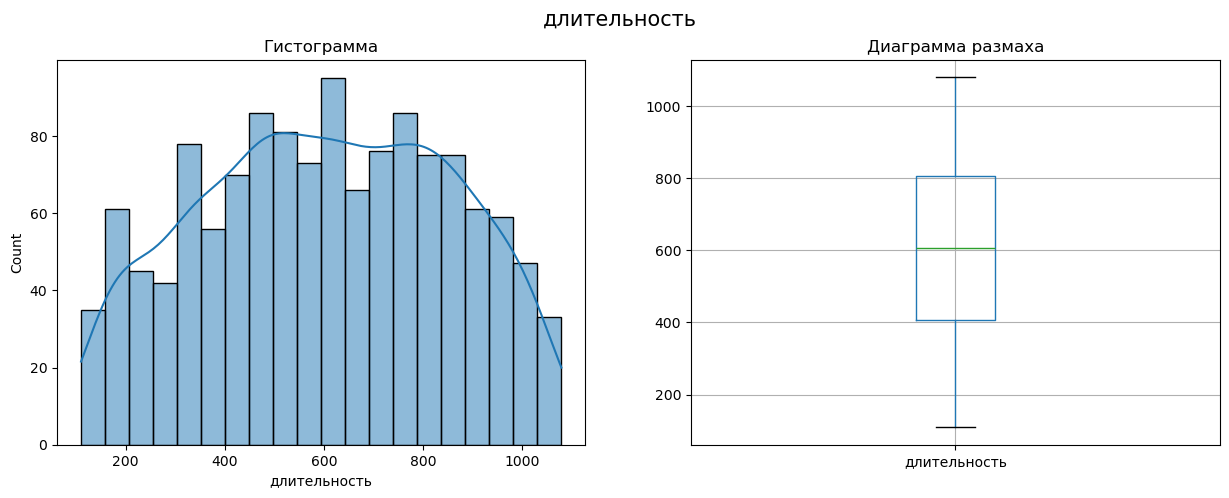

In [32]:
hist_and_boxplot('длительность', df_main, 20)

Распределение количества дней с момента регистрации покупателя на сайте похоже на нормальное, выбросов и аномальных значений нет. Число варьируется от 110 до 1079 дней, среднее значение около 600 дней. Получается, что информация собрана для клиентов зарегистрированных более 3 месяцев.

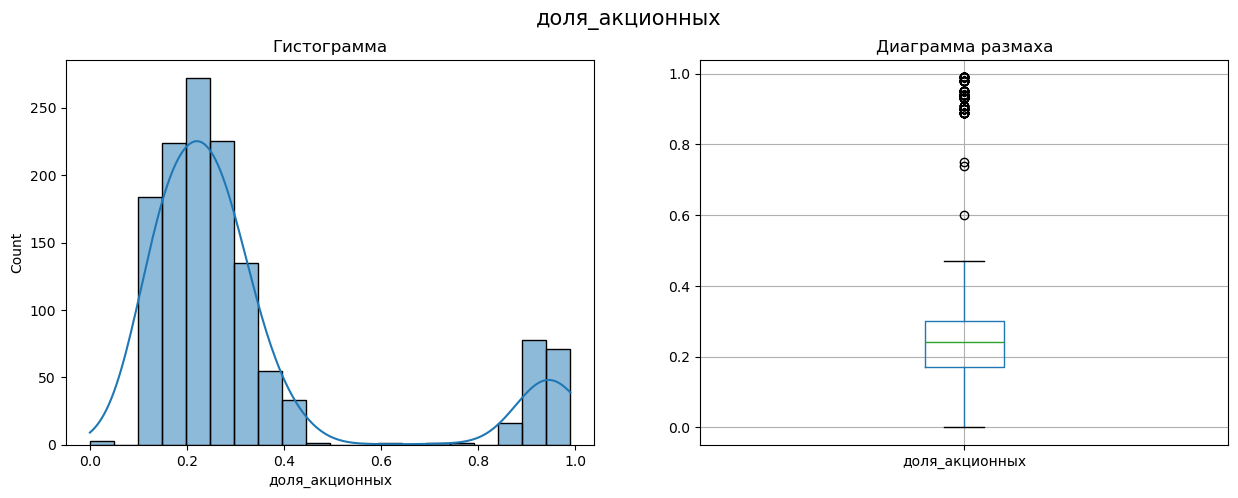

In [33]:
hist_and_boxplot('доля_акционных', df_main, 20)

Гисторамма среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев выглядит интересно: слева видно нормальное распределение, в правой части видны выбросы. Получается, что у большинства покупателей доля акционных товаров варьируется от 0 до 50 процентов, средняя доля акционных товаров около 24 процентов. Однако есть значительная часть пользователей, которые покупают товары только по акции - у них доля акционных покупок превышает 80 процентов и достигает 100.   

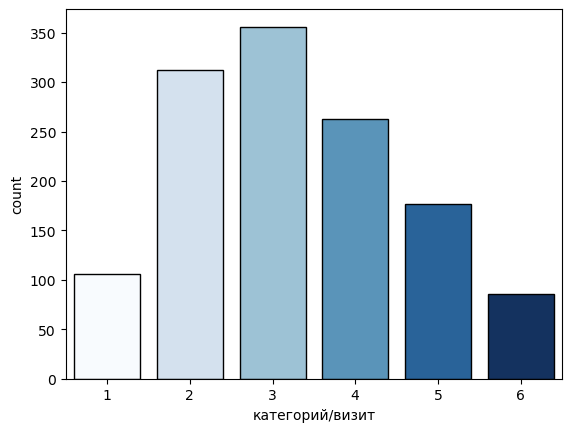

In [34]:
sns.countplot(x='категорий/визит', data=df_main, hue = 'категорий/визит', palette='Blues', edgecolor='black', legend=False)
plt.show()

Распределение количества категорий, которых покупатель просмотрел за визит в течение последнего месяца тоже похоже на нормальное. Это дискретная величина, аномальных значений не наблюдается. 

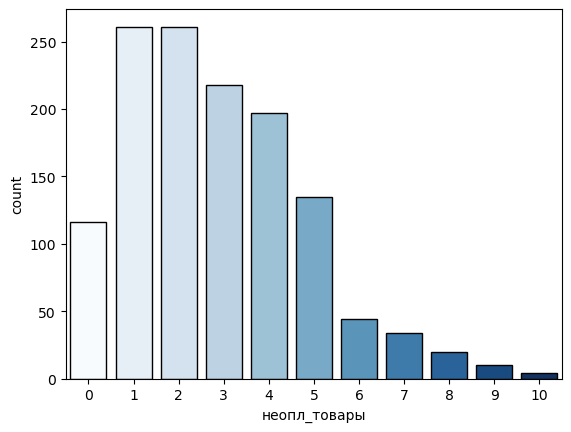

In [35]:
sns.countplot(x='неопл_товары', data=df_main, hue='неопл_товары', palette='Blues', edgecolor='black', legend=False)
plt.show()

Распределение неоплаченных товаров в корзине за последние 3 месяца похоже на распределение Пуассона, что ожидаемо. Среднее значение около 3, максимальное достигает 10. 

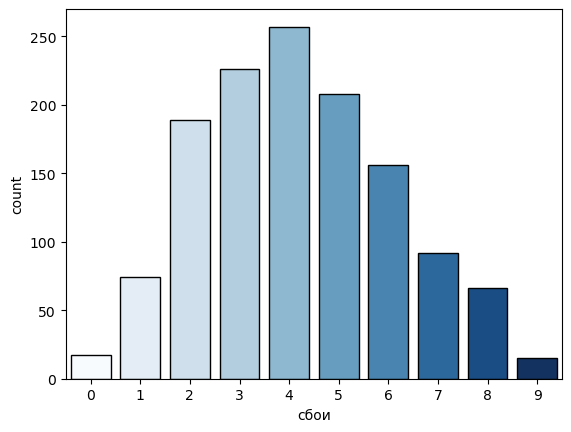

In [36]:
sns.countplot(x='сбои', data=df_main, hue='сбои', palette='Blues', edgecolor='black', legend=False)
plt.show()

Число сбоев, которые коснулись покупателя во время посещения сайта за последние 3 месяца, варьируется от 0 до 9. 

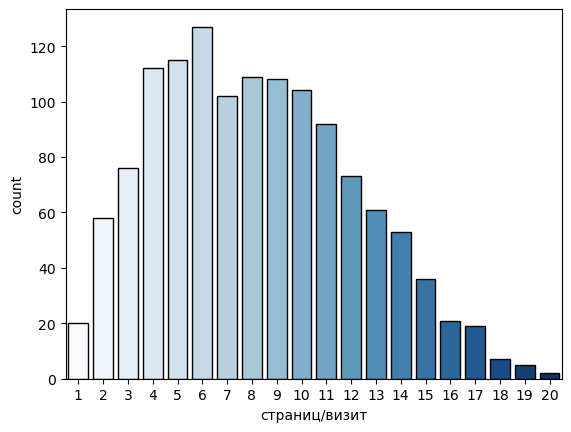

In [37]:
sns.countplot(x='страниц/визит', data=df_main, hue='страниц/визит', palette='Blues', edgecolor='black', legend=False)
plt.show()

Здесь опять наблюдается распределние Пуассона. Среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца может достигать 20, однако большинство пользователей за визит посещают около 6-8 страниц.

### Второй датафрейм

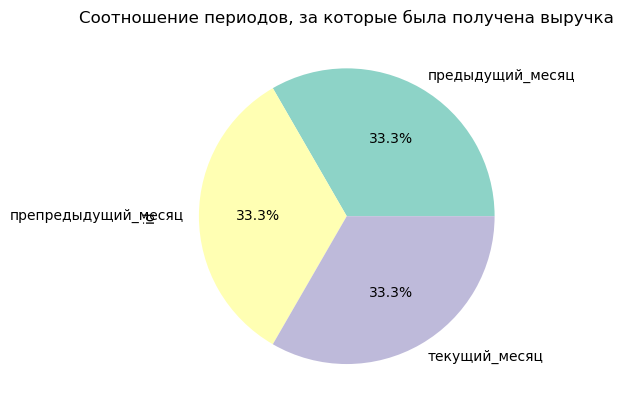

In [38]:
# используем палитру Set3
colors = plt.cm.Set3(range(3))
df_money.groupby('период')['id'].count().plot(kind='pie', colors=colors, autopct='%1.1f%%')
plt.title('Соотношение периодов, за которые была получена выручка')
plt.show()

Как и предполагалось ранее, имееются три периода времени, за которые была получена выручка: текущий и два предыдущих месяца. Данные между ними распределены равномерно.  

In [39]:
df_money['выручка'].describe().round(2)

count      3900.00
mean       5025.70
std        1777.70
min           0.00
25%        4590.15
50%        4957.50
75%        5363.00
max      106862.20
Name: выручка, dtype: float64

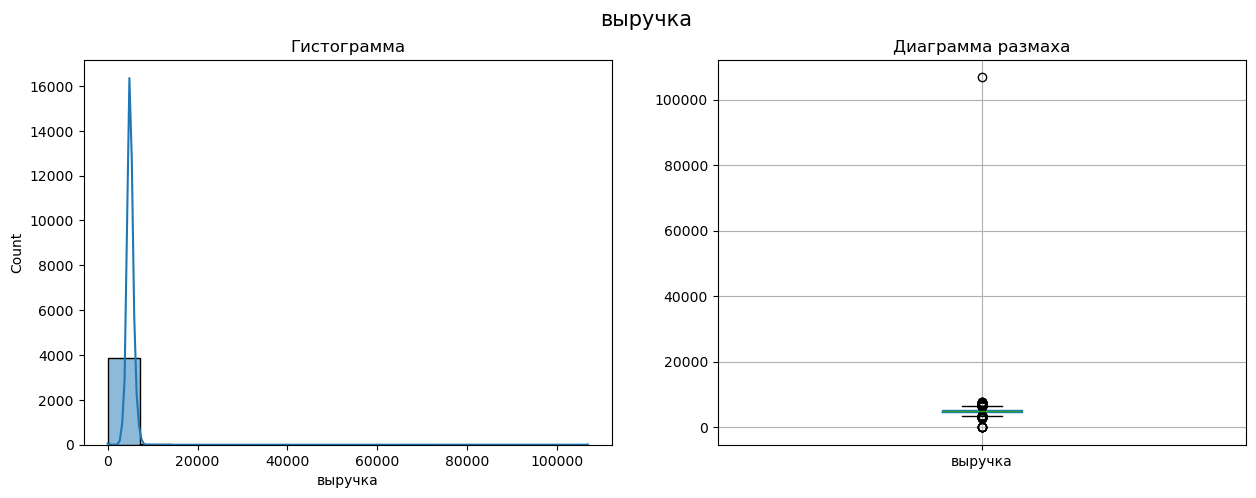

In [40]:
hist_and_boxplot('выручка', df_money, 15)

Значение среднее значение месячной выручки составляет около 5000 у.е., при этом максимальное значение достигает почти 107 тысяч у.е. Может это ошибка в данных, может реальная покупка какого-то богатого клиента, однако это значение сильно выбивается из общей картины и может помешать в дальнейшем. Заменим его на медианное значение выручки. 

In [41]:
median_value = df_money.loc[df_money['выручка'] < 20000, 'выручка'].median()
df_money.loc[df_money['выручка'] > 20000, 'выручка'] = median_value

Также нам необходимо отобрать клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Т.к. у нас и так представлены только три периода времени (три месяца), то выведем список клиентов выручка за которых за какой-то период была 0 у.е. 

In [42]:
df_money.loc[df_money['выручка'] == 0]

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


Видно, что есть только три клиента с покупательской активностью менее трех месяцев. Всего у нас было 1300 покупателей, поэтому можно спокойно удалить информацию о трех этих клиентах из всех датафреймов.  

In [43]:
# список для id неактивных клиентов
inactive_ids = []

inactive_clients = df_money[df_money['выручка'] == 0]['id'].unique()
inactive_ids.extend(inactive_clients)
print(inactive_ids)
print(f'Всего неактивных клиентов для удаления: {len(inactive_ids)}')

[215348, 215357, 215359]
Всего неактивных клиентов для удаления: 3


In [44]:
print(f'Длина df_money до удаления "неактивных" клиентов- {len(df_money)}')
df_money = df_money[~ df_money['id'].isin(inactive_ids)]
df_money = df_money.reset_index(drop=True)
print(f'Длина df_money после удаления "неактивных" клиентов - {len(df_money)}')

Длина df_money до удаления "неактивных" клиентов- 3900
Длина df_money после удаления "неактивных" клиентов - 3891


In [45]:
print(f'Длина df_main до удаления "неактивных" клиентов - {len(df_main)}')
df_main = df_main[~ df_main['id'].isin(inactive_ids)].reset_index(drop=True)
print(f'Длина df_main после удаления - {len(df_main)}')

print(f'Длина df_time до удаления "неактивных" клиентов - {len(df_time)}')
df_time = df_time[~ df_time['id'].isin(inactive_ids)].reset_index(drop=True)
print(f'Длина df_time после удаления "неактивных" клиентов - {len(df_time)}')

print(f'Длина df_profit до удаления "неактивных" клиентов  - {len(df_profit)}')
df_profit = df_profit[~ df_profit['id'].isin(inactive_ids)].reset_index(drop=True)
print(f'Длина df_profit после удаления "неактивных" клиентов - {len(df_profit)}')

Длина df_main до удаления "неактивных" клиентов - 1300
Длина df_main после удаления - 1297
Длина df_time до удаления "неактивных" клиентов - 2600
Длина df_time после удаления "неактивных" клиентов - 2594
Длина df_profit до удаления "неактивных" клиентов  - 1300
Длина df_profit после удаления "неактивных" клиентов - 1297


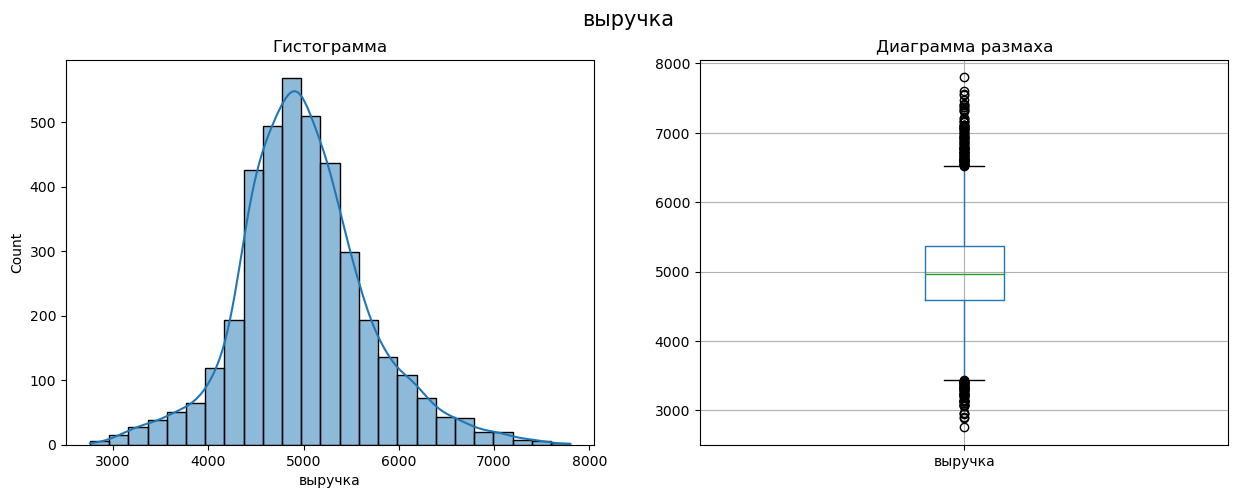

In [46]:
hist_and_boxplot('выручка', df_money, 25)

Распределение похоже на нормальное, с небольшим сдвигом в меньшую сторону. Средняя выручка около 5 тысяч у.е., максимальная достигает почти 8 тыс.

### Третий датафрейм

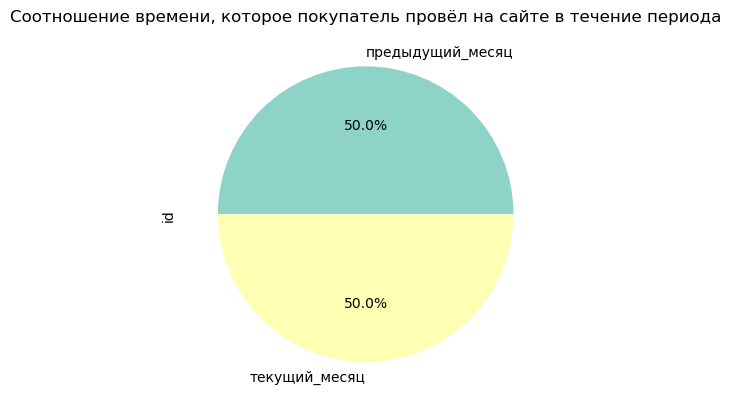

In [47]:
# используем палитру Set3
colors = plt.cm.Set3(range(2))
df_time.groupby('период')['id'].count().plot(kind='pie', colors=colors, autopct='%1.1f%%')
plt.title('Соотношение времени, которое покупатель провёл на сайте в течение периода')
plt.show()

Злесь видно, что имеющиеся данные распределены равномерно по двум периодам времени: текущий и предыдущий месяц. 

In [48]:
df_time['общее_время'].describe()

count    2594.000000
mean       13.340401
std         4.081999
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: общее_время, dtype: float64

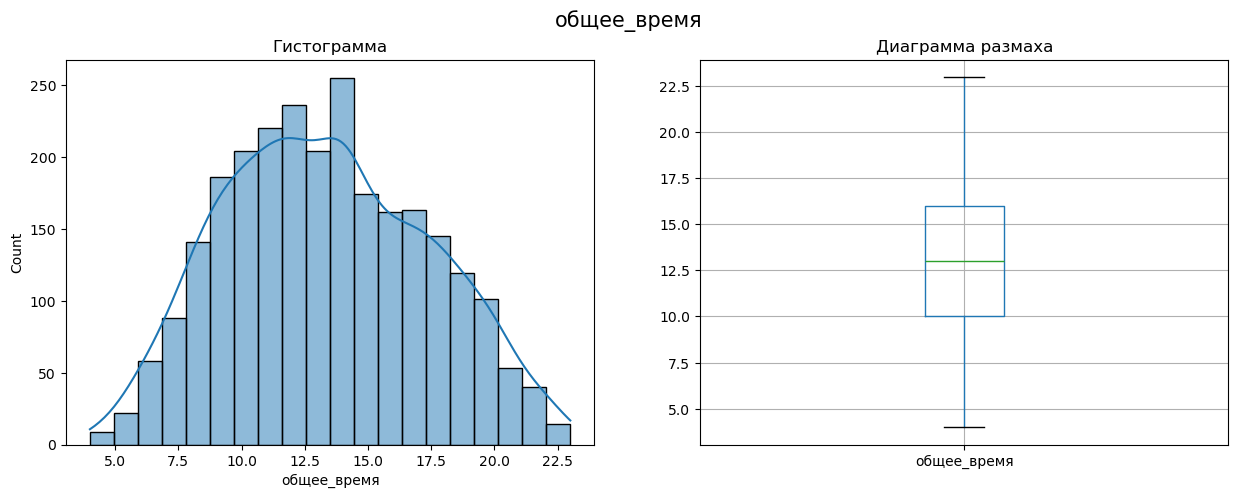

In [49]:
hist_and_boxplot('общее_время', df_time, 20)

Время, которое покупатель провёл на сайте варьируется от 4 до 23 минут, среднее значение около 13 минут. Распределение похож на нормальное, выбросов и аномалий нет.

### Четвертый датафрейм 

In [50]:
df_profit['средняя_прибыль'].describe()

count    1297.000000
mean        3.997610
std         1.010813
min         0.860000
25%         3.300000
50%         4.040000
75%         4.670000
max         7.430000
Name: средняя_прибыль, dtype: float64

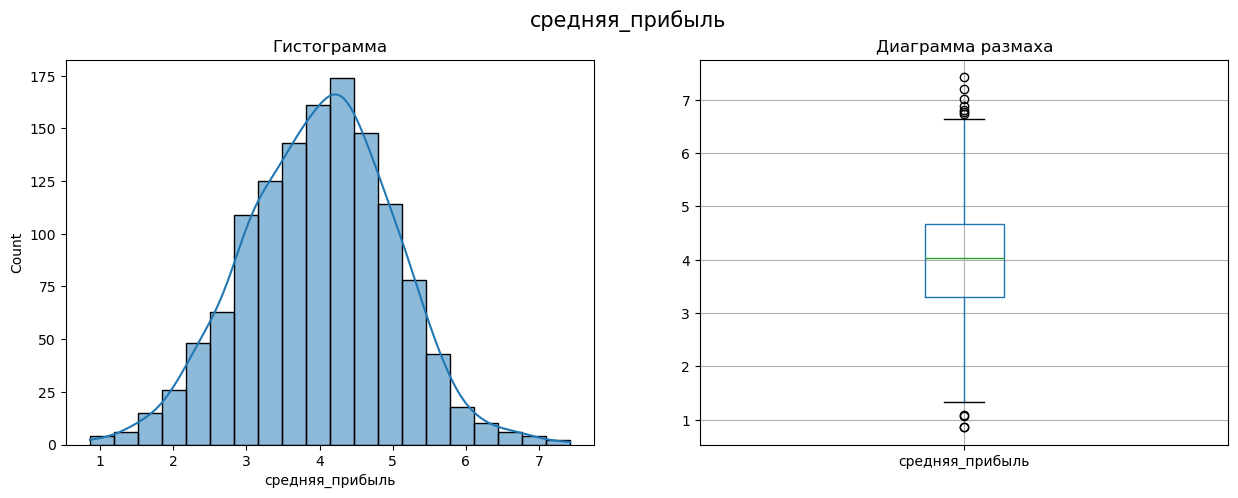

In [51]:
hist_and_boxplot('средняя_прибыль', df_profit, 20)

Средняя прибыль в месяц полученная продавцом от каждого покупателя варьируется от примерно 1 у.е. до 7,5 у.е. Распределение похоже на нормальное, среднее значение около 4 у.е. На диаграмме размаха видны выбросы, но они не сильно выбиваются из общей картины.

**Вывод:** Провели исследовательский анализ данных из каждой таблицы и отбрали клиентов с покупательской активностью не менее трёх месяцев

* Покупательская активность снизилась у примерно 38 процентов пользователей
* Около 29 процентов покупателей имеют премиум подписку и 26 процентов не получают рекламные предложения
* Любимыми категориями клиентов явлются товары для детей, домашний текстиль, косметика и аксессуары. Наименее востребованная категория - кухонная посуда 
* Маркетинговые активности (показ рекламы/звонки/рассылки) показывают среднее значение 4 контакта в месяц на одного клиента за последние полгода.
* Анализ распределения дней с момента регистрации пользователя показал близость к нормальному распределению без существенных выбросов. Временной диапазон охватывает 110–1079 дней при среднем значении около 600 дней.
* Анализ гистограммы среднемесячной доли акционных покупок за последние полгода выявил интересную структуру распределения:
основная масса покупателей демонстрирует нормальное распределение с долей акционных товаров от 0% до 50%, где средняя доля акционных покупок составляет 24%, также наблюдаются выбросы, характеризующие особую группу клиентов - совершающих покупки исключительно по акциям
* Распределения числа категорий, которых покупатель просмотрел за визит в течение последнего месяца, и число сбоев, которые произошли во время посещения клиентом сайта за последние 3 месяца,  похожи на нормальные распределения, а распределения числа неоплаченных товаров в корзине и количества страниц, которые просмотрел покупатель за визит за последние 3 месяца - на распределения Пуассона.
* Средняя выручка от каждого покупателя около 5 тысяч у.е. При этом мы избавились от аномального высокого значения выручки и отбрали клиентов с покупательской активностью не менее трёх месяцев
* Среднее значение времени которое покупатель проводит на сайте составляет около 13 минут
* Средняя среднемесячная прибыль полученная от покупателя около 4 у.е.

## Объединение таблиц

Объединим таблицы df_main, df_money, df_time в одну. При этом заметим, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице **data** сделаем отдельный столбец для каждого периода.

In [52]:
df_money_grouped = df_money.pivot_table(index=['id'], columns=['период'])
df_money_grouped.columns = ['выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']

df_time_grouped = df_time.pivot_table(index=['id'], columns=['период'])
df_time_grouped .columns = ['время_предыдущий_месяц', 'время_текущий_месяц']

data = df_main.merge(df_money_grouped, on='id').merge(df_time_grouped, on='id')
data.head()

,id,активность,уровень,рассылки,маркетинг_6_мес,маркетинг_текущ,длительность,доля_акционных,топ-категория,категорий/визит,неопл_товары,сбои,страниц/визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0


In [53]:
# выведем размеры трех исходных и итогового датафреймов
print(df_main.shape)
print(df_money.shape)
print(df_time.shape)
print(data.shape)

(1297, 13)
(3891, 3)
(2594, 3)
(1297, 18)


In [54]:
# выведем количество пропусков и дубликатов
print(data.isna().sum().sum())
data.duplicated().sum()

0


0

In [55]:
# выведем информацию о новом датафрейме
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1297 non-null   int64  
 1   активность                   1297 non-null   object 
 2   уровень                      1297 non-null   object 
 3   рассылки                     1297 non-null   object 
 4   маркетинг_6_мес              1297 non-null   float64
 5   маркетинг_текущ              1297 non-null   int64  
 6   длительность                 1297 non-null   int64  
 7   доля_акционных               1297 non-null   float64
 8   топ-категория                1297 non-null   object 
 9   категорий/визит              1297 non-null   int64  
 10  неопл_товары                 1297 non-null   int64  
 11  сбои                         1297 non-null   int64  
 12  страниц/визит                1297 non-null   int64  
 13  выручка_предыдущий

После объединения данные из трех датафреймов хранятся в data. Его длина 1297 строчки, 17 столбцов, пропусков и дубликатов нет. 

**Вывод:** На данном этапе работы мы объединили 3 таблицы в одну для дальнейшего удобства. Проверили размер и отсутствие пропусков и дубликатов

## Корреляционный анализ

Построим матрицу корреляции

In [56]:
interval_cols= data[['маркетинг_6_мес', 'длительность', 'доля_акционных', 'выручка_предыдущий_месяц', \
                     'выручка_препредыдущий_месяц', 'выручка_текущий_месяц']]

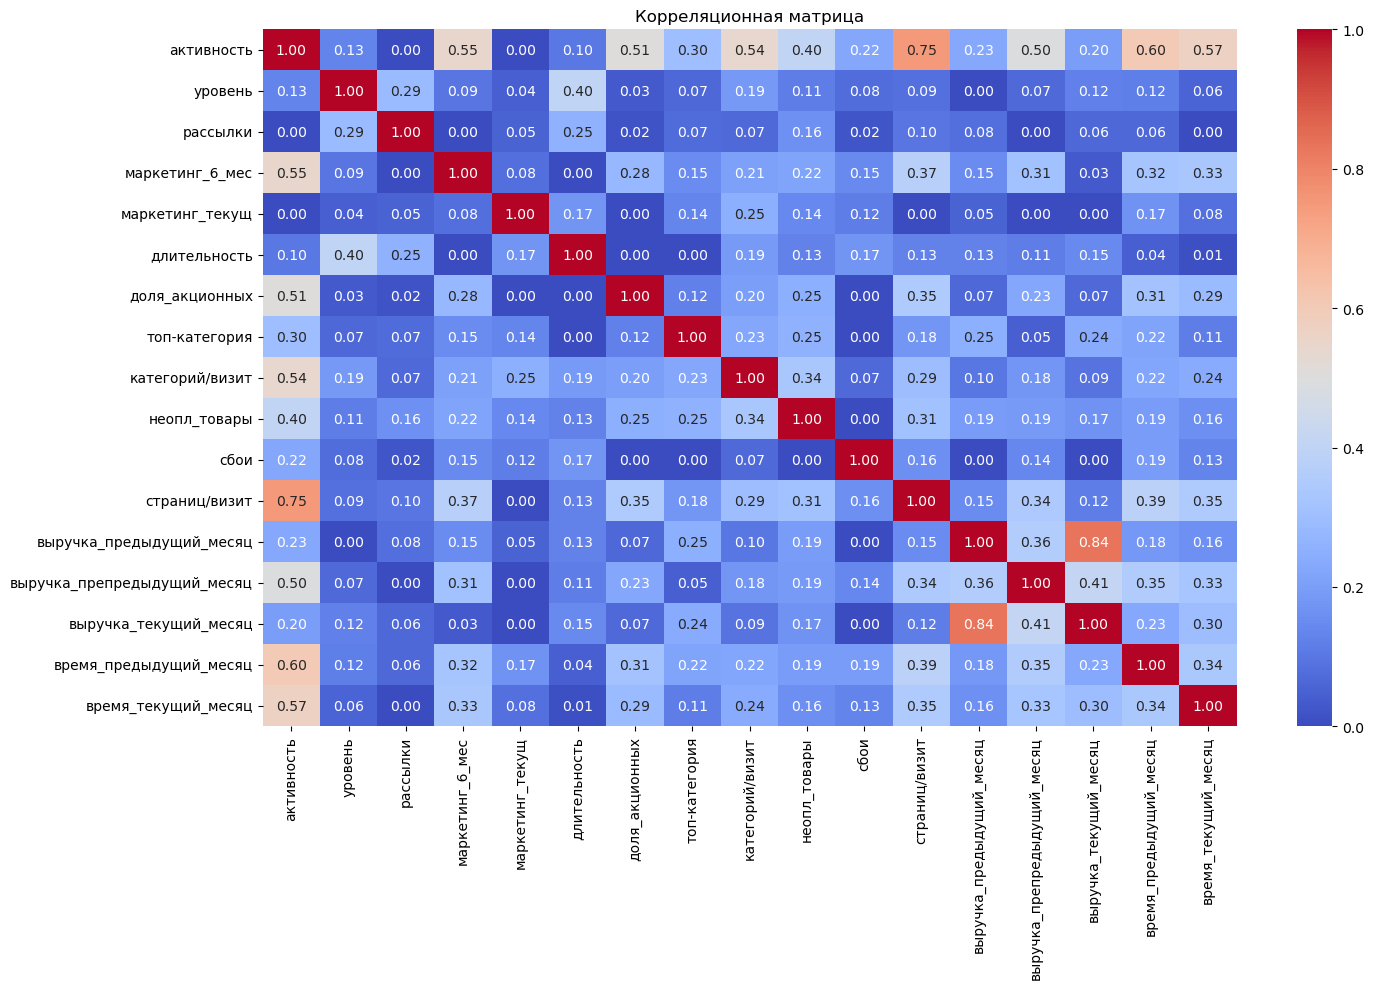

In [57]:
phik_matrix = data.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
plt.figure(figsize=(15, 10))
sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Корреляционная матрица")
plt.tight_layout()
plt.show()

Целевой признак **активность** коррелирует с признаками: *маркетинг_ 6_мес*, *доля_акционных*, *категорий_визит*, *неопл_товары*, *страниц_визит*, *выручка_препредыдущий_месяц*, *время_предыдущий_месяц*, *время_текущий_месяц*. Наибольшая корреляция наблюдается с признаками *страниц_визит* и *время_предыдущий_месяц*.

У входных признаков видна высокая корреляция между *выручка_текущий_месяц* и *выручка_предыдущий_месяц*. Проведем дополнительный анализ VIF.

In [58]:
X = sm.add_constant(interval_cols)
vif = pd.DataFrame()
vif['признаки'] = X.columns
vif['vif'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

                      признаки         vif
0                        const  270.114154
1              маркетинг_6_мес    1.118825
2                 длительность    1.004034
3               доля_акционных    1.091426
4     выручка_предыдущий_месяц    4.119841
5  выручка_препредыдущий_месяц    1.358001
6        выручка_текущий_месяц    3.706807


Коэффициент VIF меньше 5, что говорит об умеренной мультиколлинеарности, удалять переменные не будем.

**Выводы:**
* Наблюдается средняя связь между покупательной активностью и маркетинговыми коммуникациями за полгода, а также между покупателькой активностью и долей акционных товаров
* Также средняя корреляция наблюдается между покупательской активностью и средним временем провденным покупателем на сайте
* Слабая коррреляция наблюдается между целевым признаком и выручкой за разные периоды времени (только с выручкой за предыдущий месяц корреляция больше - 0.5)
* Средняя связь между покупателькой активностью и средним числом категорий, рассматриваемых пользователем за один визит  
* Сильная связь между покупателькой активностью и средним числом страниц, посещаемых пользователем за один визит  
* Хотя и видна высокая корреляция между показателями выручки, значение VIF не превышает критического порога (VIF < 5), что говорит об отсутствии существенной мультиколлинеарности в модели

## Использование пайплайнов 

In [59]:
# скопируем данные для дальнейшего использования
data_all = data.copy()

In [60]:
#data['активность'] = data['активность'].apply( lambda x: 1 if x=='снизилась' else 0 )
#data['активность'] = data['активность'].astype(int)    

In [61]:
# устанавливаем столбец 'id' в качестве индекса
data = data.set_index('id')
data.head()

,активность,уровень,рассылки,маркетинг_6_мес,маркетинг_текущ,длительность,доля_акционных,топ-категория,категорий/визит,неопл_товары,сбои,страниц/визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
id,,,,,,,,,,,,,,,,,
215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0


In [62]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

# определяем целевой и входные признаки
X = data.drop(['активность'], axis=1)
y = data['активность']
# разделяем набор данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = y)

In [63]:
# Создаем LabelEncoder для целевой переменной
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [64]:
# создаём списки с названиями признаков
ohe_columns = ['топ-категория']
ord_columns = ['рассылки', 'уровень']
num_columns = ['маркетинг_6_мес', 'маркетинг_текущ', 'длительность', 'категорий/визит','неопл_товары',\
                     'сбои', 'страниц/визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц',\
                     'выручка_текущий_месяц', 'время_предыдущий_месяц', 'время_текущий_месяц', 'доля_акционных']

In [65]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
    ]
)

In [66]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [
        (
            'simple_imputer_ord_before',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(categories=[
                               ['нет', 'да'],
                               ['стандарт', 'премиум']
                
                          ],
                          handle_unknown='use_encoded_value',
                          unknown_value=np.nan)
        ),
        (
            'simple_imputer_ord_after',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [67]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [68]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [69]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 15),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': [0.001, 0.01, 0.1, 1, 10],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    }
]

In [70]:
# запускаем автоматический подбор 
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

Для оценки качества моделей выбрана метрика ROC-AUC, которая подходит для бинарной классификации с несбалансированной выборкой. В нашем случае пользователей с прежним уровнем покупательской актичностью значительно больше, чем пользователей со сниженной активностью

In [71]:
randomized_search.fit(X_train, y_train)

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","[{'models': [DecisionTreeC...ndom_state=42)], 'models__max_depth': range(2, 5), 'models__max_features': range(2, 15), 'models__min_samples_split': range(2, 10), ...}, {'models': [KNeighborsClassifier()], 'models__n_neighbors': range(2, 5), 'preprocessor__num': [StandardScaler(), MinMaxScaler(), ...]}, ...]"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",10
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These split

In [72]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика по тренировочной выборке:', round(randomized_search.best_score_, 2))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['топ-категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simple_imputer_ord_before',
                 

In [73]:
y_test_pred = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.8800954902904831


In [74]:
# создание и обучение модели DummyClassifier 
dummy_model = DummyClassifier(random_state=RANDOM_STATE, strategy='most_frequent')
dummy_model.fit(X_train, y_train)

# предсказание на тестовых данных
dummy_model_probas = dummy_model.predict_proba(X_test)[:,1]

# посчитаем и выведем метрику ROC-AUC
dummy_roc = roc_auc_score(y_test, dummy_model_probas)
print('ROC-AUC =', round(dummy_roc,2))


ROC-AUC = 0.5


Модель лучше константной

**Вывод:**
На данном этапе было выполнено обучение нескольких моделей посредством конвейера.
* Были обработаны отдельно количественные и категориальные признаки 
* Обучены 3 модели: **KNeighborsClassifier**, **DecisionTreeClassifier**, **LogisticRegression** 
* Для подбора гиперпараметров использовался рандомизированный поиск для более быстрого поиска
* Для оценки качества моделей выбрана метрика ROC-AUC, которая подходит для бинарной классификации с несбалансированной выборкой. В нашем случае пользователей с прежним уровнем покупательской актичностью значительно больше, чем пользователей со сниженной активностью
* В результате метрика ROC-AUC достигла 0.88 на тестовой выборке для модели **DecisionTreeClassifier**,
это хороший показатель качества модели 

## Анализ важности признаков

Оценим важность признаков для лучшей модели и построим график важности с помощью метода SHAP

In [75]:
# лучшая найденная модель
best_model = randomized_search.best_estimator_.named_steps['models']
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
# предобработка 
X_train_processed = preprocessor.transform(X_train)
feature_names = preprocessor.get_feature_names_out()
explainer = shap.Explainer(best_model.predict_proba, X_train_processed, feature_names=feature_names) 
shap_values = explainer(X_train_processed)

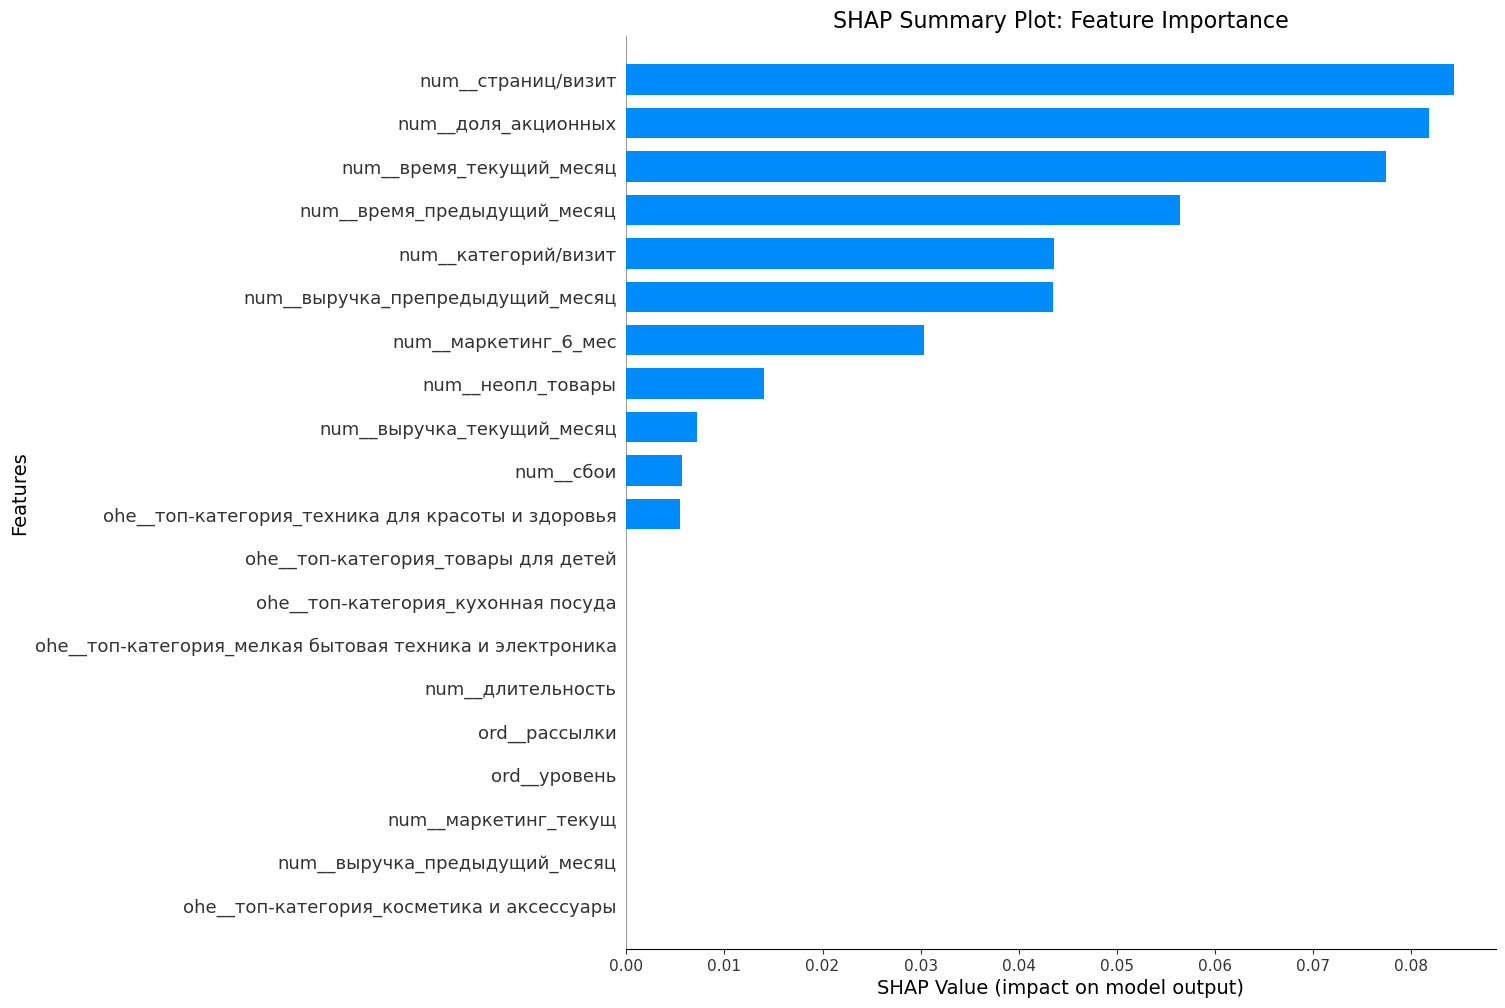

In [76]:
plt.rcParams.update({'font.size': 13})
rng = np.random.default_rng()
shap.summary_plot(
    shap_values [:,:,1], 
    X_train_processed, 
    plot_type="bar", 
    max_display=20, 
    plot_size=(15, 10), 
    rng=rng,
    show=False
)

fig, ax = plt.gcf(), plt.gca()
# настраиваем заголовок и оси
ax_title = 'SHAP Summary Plot: Feature Importance'
font_size = 16
ax.set_title(ax_title, fontdict={"size": font_size})
ax.set_xlabel('SHAP Value (impact on model output)', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
# показываем график
plt.show()

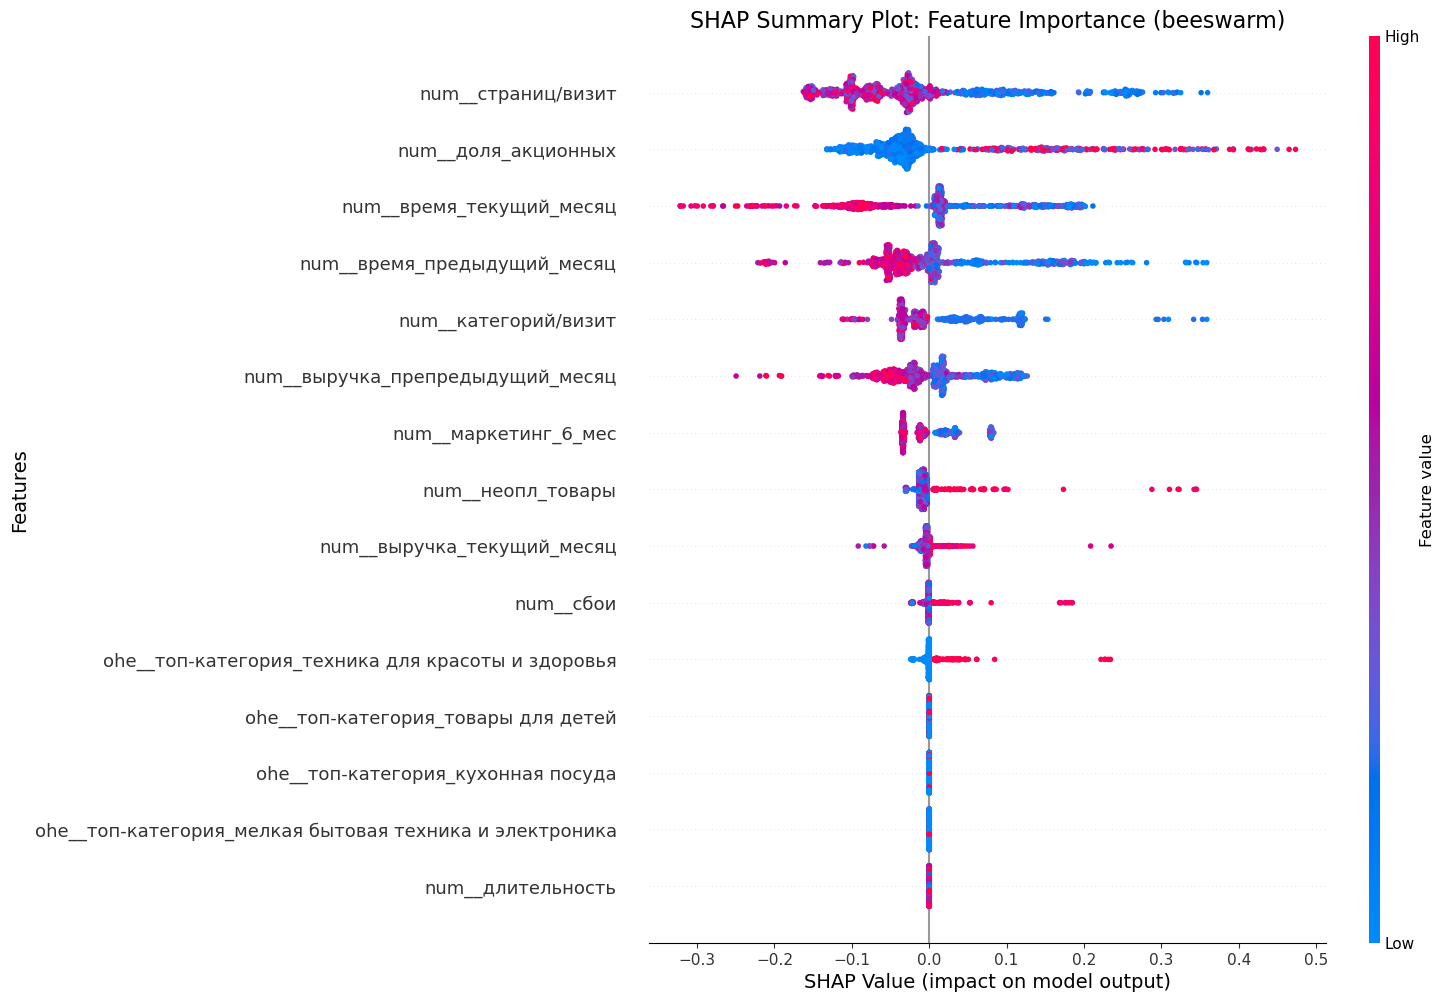

In [77]:
plt.rcParams.update({'font.size': 13})
rng = np.random.default_rng()
shap.summary_plot(
    shap_values [:,:,1], 
    X_train_processed, 
    plot_type="dot", 
    max_display=15, 
    plot_size=(15, 10),
    rng=rng,
    show=False
)
fig, ax = plt.gcf(), plt.gca()
# настраиваем заголовок и оси
ax_title = 'SHAP Summary Plot: Feature Importance (beeswarm)'
font_size = 16
ax.set_title(ax_title, fontdict={"size": font_size})
ax.set_xlabel('SHAP Value (impact on model output)', fontsize=14)
ax.set_ylabel('Features', fontsize=14)
# показываем график
plt.show()

**Выводы:**
* Мало значимы для модели выручка и маркетинг в текущем месяце, а также топ-категории и уровень подписки 
* Сильнее всего влияют на целевой признак:
1. количество времени проведенное пользователем на сайте в текущем и в предудущем месяце
2. количество страниц, посещенных пользователем за один визит
3. количество покупок по акции
4. выручка в препредудущем месяце
5. количество неоплаченных товаров 

* Для количества времени, количества страниц и суммы выручки связь с снижением покупательской активности отрицательная: чем больше значения этих признаков, тем вероятнее покупателькая активность будет оставаться на том же уровне. 
* Для акционных товаров все и количества неоплаченных товаров наоборот: большие значения повышают вероятность того, что покупателькая активность будет снижаться. Таким образом, стоит уделить внимание этим входным признакам: например, можно попробовать увеличить доли акционных товаров для стимулирования активности и контролировать количество неоплаченных товаров в корзине.

## Сегментация покупателей

Анализ признаков показал, что высокое значение признака *доля_акционных* повышает вероятность снижения покупательской активности. При этом на гистограмме распределения было видно, что есть значительная часть пользователей, которые покупают товары только по акции - у них доля акционных покупок превышает 80 процентов и достигает 100.   

Поэтому для анализа выберем группу клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности.

### Сегментация

In [78]:
# выведем информацию о всех клиентах магазина
data_all.head()

,id,активность,уровень,рассылки,маркетинг_6_мес,маркетинг_текущ,длительность,доля_акционных,топ-категория,категорий/визит,неопл_товары,сбои,страниц/визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0


In [79]:
# добавим информацию о средней прибыли из четвертого датафрейма
data_all = data_all.merge(df_profit, on='id', how='left')
data_all.head()

,id,активность,уровень,рассылки,маркетинг_6_мес,маркетинг_текущ,длительность,доля_акционных,топ-категория,категорий/визит,неопл_товары,сбои,страниц/визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,средняя_прибыль
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0,4.16
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0,3.13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0,4.87
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0,4.21
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0,3.95


In [80]:
# добавим столбец с прогнозом модели
predictions = randomized_search.predict_proba(data_all)

temp_1 = pd.DataFrame({'прогноз': predictions[:, 1]})
temp_2 = temp_1['прогноз']
data_all = data_all.merge(temp_2, left_index=True, right_index=True)

data_all.head(5)

,id,активность,уровень,рассылки,маркетинг_6_мес,маркетинг_текущ,длительность,доля_акционных,топ-категория,категорий/визит,неопл_товары,сбои,страниц/визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,средняя_прибыль,прогноз
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0,4.16,0.980892
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0,3.13,0.517241
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0,4.87,0.980892
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0,4.21,0.980892
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0,3.95,0.517241


In [81]:
data_all['прогноз'] = data_all['прогноз'].apply(lambda x: 'снизится' if x >= 0.5 else 'останется_прежней')
data_all.head()

,id,активность,уровень,рассылки,маркетинг_6_мес,маркетинг_текущ,длительность,доля_акционных,топ-категория,категорий/визит,неопл_товары,сбои,страниц/визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,средняя_прибыль,прогноз
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0,4.16,снизится
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8.0,13.0,3.13,снизится
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0,4.87,снизится
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0,4.21,снизится
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10.0,10.0,3.95,снизится


Выберем сегмент покупателей у которых доля акционных покупок больше 50 процентов и для которых модель предсказывает снижение покупательской активности

In [82]:
data_segment = data_all[(data_all['доля_акционных'] >= 0.5) & (data_all['прогноз'] == 'снизится')]
data_segment.head()

,id,активность,уровень,рассылки,маркетинг_6_мес,маркетинг_текущ,длительность,доля_акционных,топ-категория,категорий/визит,неопл_товары,сбои,страниц/визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,средняя_прибыль,прогноз
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0,4.16,снизится
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0,4.87,снизится
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0,4.21,снизится
11,215362,снизилась,премиум,да,4.2,4,438,0.74,домашний текстиль,3,4,6,4,4314.0,4765.0,4447.9,13.0,13.0,3.49,снизится
13,215364,снизилась,премиум,да,4.3,4,708,0.98,домашний текстиль,3,3,3,3,5795.5,4942.0,5484.8,11.0,9.0,2.67,снизится


In [83]:
data_segment = data_segment[data_segment['средняя_прибыль'] >= data_all['средняя_прибыль'].mean()]
data_segment.head()

,id,активность,уровень,рассылки,маркетинг_6_мес,маркетинг_текущ,длительность,доля_акционных,топ-категория,категорий/визит,неопл_товары,сбои,страниц/визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,средняя_прибыль,прогноз
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12.0,10.0,4.16,снизится
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11.0,13.0,4.87,снизится
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8.0,11.0,4.21,снизится
23,215374,снизилась,стандарт,нет,2.9,5,268,0.98,домашний текстиль,6,3,2,2,5762.5,4666.0,5720.9,11.0,8.0,4.08,снизится
24,215375,снизилась,премиум,да,3.0,4,558,0.89,товары для детей,3,3,7,4,5253.5,4715.0,5633.1,8.0,9.0,4.18,снизится


In [84]:
data_segment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 0 to 1213
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           63 non-null     int64  
 1   активность                   63 non-null     object 
 2   уровень                      63 non-null     object 
 3   рассылки                     63 non-null     object 
 4   маркетинг_6_мес              63 non-null     float64
 5   маркетинг_текущ              63 non-null     int64  
 6   длительность                 63 non-null     int64  
 7   доля_акционных               63 non-null     float64
 8   топ-категория                63 non-null     object 
 9   категорий/визит              63 non-null     int64  
 10  неопл_товары                 63 non-null     int64  
 11  сбои                         63 non-null     int64  
 12  страниц/визит                63 non-null     int64  
 13  выручка_предыдущий_месяц 

Найдем долю прибыли от выбранного сегмента 

In [85]:
(data_segment['средняя_прибыль'].sum()/data_all['средняя_прибыль'].sum()).round(2)

0.06

Таким образом, группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности приносят сейчас около 6 процентов от общей прибыли. Это довольно значимая часть, учитывая то, что снизилась активность у примерно 40 процентов пользователей.


### Графическое и аналитическое исследование группы покупателей

Выведем соотношение двух типов подписок для всех покупателей и выбранного сегмента (покупатели с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности)

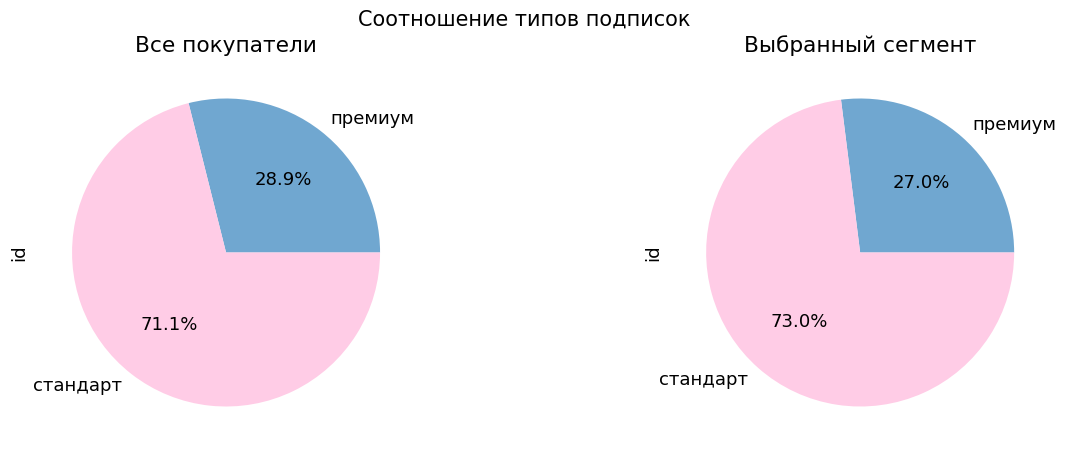

In [86]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
data_all.groupby('уровень')['id'].count().plot(kind='pie', colors=['#70a7d0','#ffcce6'], autopct='%1.1f%%')
plt.title('Все покупатели')
plt.subplot(1, 2, 2)
data_segment.groupby('уровень')['id'].count().plot(kind='pie', colors=['#70a7d0','#ffcce6'], autopct='%1.1f%%')
plt.title('Выбранный сегмент')
plt.suptitle('Соотношение типов подписок', fontsize=15)
plt.show()

Видно, что у выбранной группы меньше процент пользователей с подпиской, однако эта разница небольшая. Посмотрим как обстоят дела с рассылками.

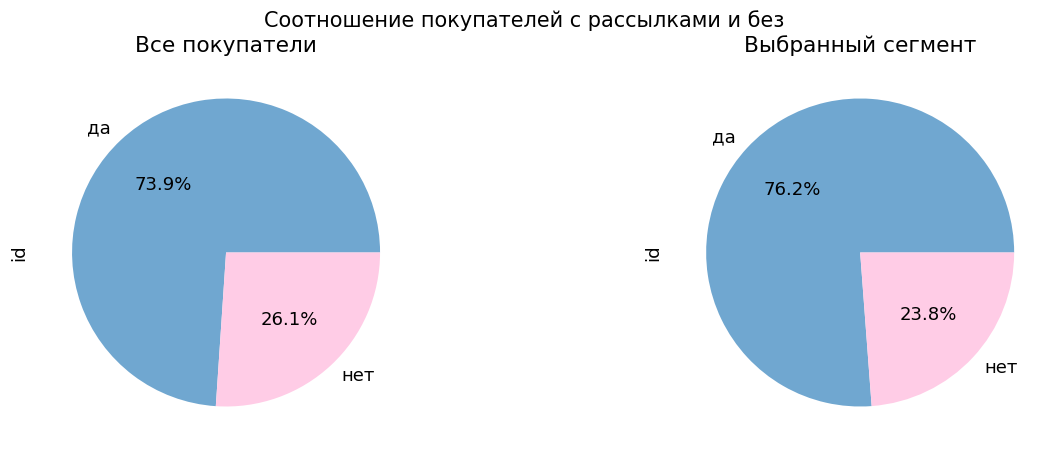

In [87]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
data_all.groupby('рассылки')['id'].count().plot(kind='pie', colors=['#70a7d0','#ffcce6'], autopct='%1.1f%%')
plt.title('Все покупатели')
plt.subplot(1, 2, 2)
data_segment.groupby('рассылки')['id'].count().plot(kind='pie', colors=['#70a7d0','#ffcce6'], autopct='%1.1f%%')
plt.title('Выбранный сегмент')
plt.suptitle('Соотношение покупателей с рассылками и без', fontsize=15)
plt.show()

Разницы в распределениях пользователей, согласных на рассылки и не согласных, нет

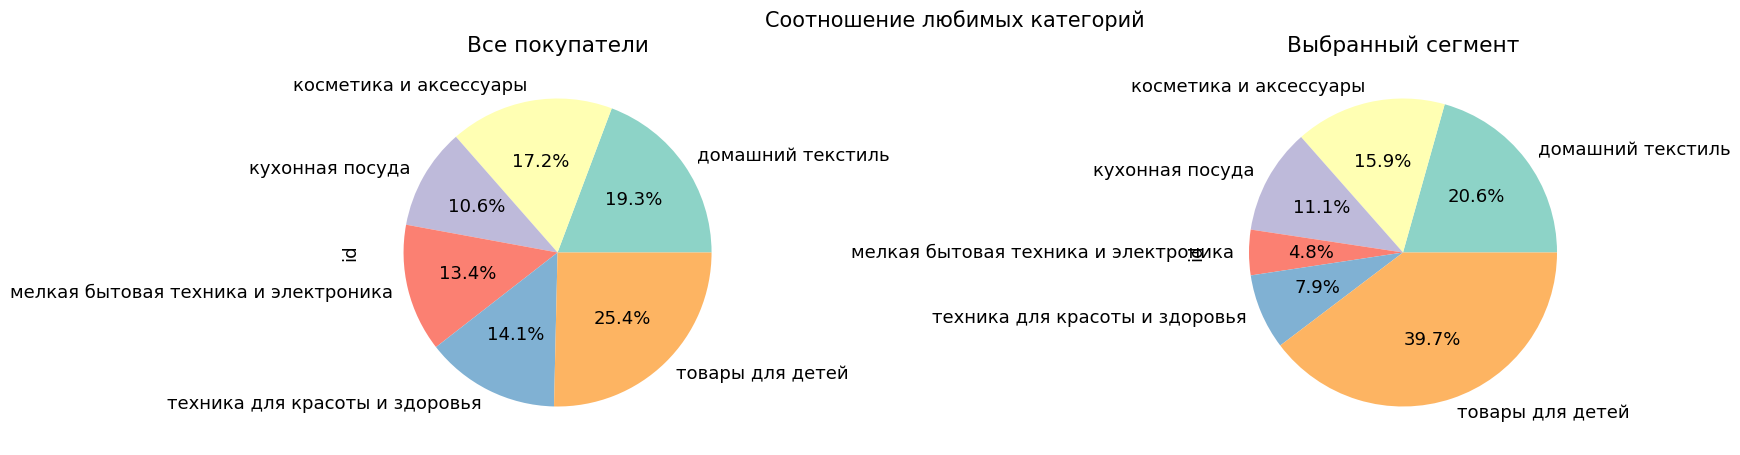

In [88]:
colors = plt.cm.Set3(range(6))
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
data_all.groupby('топ-категория')['id'].count().plot(kind='pie', colors=colors, autopct='%1.1f%%')
plt.title('Все покупатели')
plt.subplot(1, 2, 2)
data_segment.groupby('топ-категория')['id'].count().plot(kind='pie', colors=colors, autopct='%1.1f%%')
plt.title('Выбранный сегмент')
plt.suptitle('Соотношение любимых категорий', fontsize=15)
plt.show()

Среди выбранного сегмента покупателей большей популярностью пользуются товары для детей, также вырос спрос для косметики и аксессуаров и домашнего текстиля, при этом заметно снизился процент для мелкой бытовой техники и электроники и техники для красоты и здоровья. Можно сделать вывод, что большей популярностью пользуются товары в нижнем ценовом сегменте.    

Выведем описания количественных признаков для всех пользователей и выбранной группы для сравнения.

In [89]:
data_all.describe().round(2)

,id,маркетинг_6_мес,маркетинг_текущ,длительность,доля_акционных,категорий/визит,неопл_товары,сбои,страниц/визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,средняя_прибыль
count,1297.00,1297.00,1297.00,1297.00,1297.00,1297.00,1297.00,1297.00,1297.00,1297.00,1297.00,1297.00,1297.00,1297.00,1297.00
mean,215998.99,4.25,4.01,602.99,0.32,3.27,2.84,4.18,8.19,4948.34,4836.37,5237.88,13.47,13.21,4.00
std,374.58,1.02,0.70,249.10,0.25,1.35,1.97,1.95,3.98,701.23,333.44,834.03,3.94,4.22,1.01
min,215349.00,0.90,3.00,121.00,0.11,1.00,0.00,0.00,1.00,2890.00,4098.00,2758.70,5.00,4.00,0.86
25%,215675.00,3.70,4.00,410.00,0.17,2.00,1.00,3.00,5.00,4498.50,4585.00,4706.60,11.00,10.00,3.30
50%,215999.00,4.20,4.00,607.00,0.24,3.00,3.00,4.00,8.00,5005.50,4812.00,5179.60,13.00,13.00,4.04
75%,216323.00,4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00,5409.00,5055.00,5758.60,17.00,16.00,4.67
max,216647.00,6.60,5.00,1079.00,0.99,6.00,10.00,9.00,20.00,6869.50,5663.00,7799.40,23.00,23.00,7.43


In [90]:
data_segment.describe().round(2)

,id,маркетинг_6_мес,маркетинг_текущ,длительность,доля_акционных,категорий/визит,неопл_товары,сбои,страниц/визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,средняя_прибыль
count,63.00,63.00,63.00,63.00,63.00,63.00,63.00,63.00,63.00,63.00,63.00,63.00,63.00,63.00,63.00
mean,215580.32,3.58,3.95,614.24,0.94,2.56,4.24,4.02,4.48,4836.91,4615.60,5132.88,9.90,10.43,4.62
std,212.99,1.06,0.68,230.62,0.04,1.20,2.58,1.81,2.53,852.81,242.55,915.25,2.54,2.68,0.57
min,215349.00,0.90,3.00,171.00,0.75,1.00,0.00,2.00,1.00,3146.00,4119.00,3232.20,5.00,4.00,4.00
25%,215437.50,3.00,3.50,475.50,0.93,2.00,2.00,3.00,2.50,4314.00,4443.50,4444.25,8.00,9.00,4.26
50%,215565.00,3.90,4.00,564.00,0.94,2.00,4.00,4.00,4.00,4853.00,4596.00,5123.30,10.00,10.00,4.42
75%,215661.50,4.10,4.00,808.50,0.96,3.00,6.00,5.00,6.00,5559.25,4755.50,5826.45,12.00,12.00,4.86
max,216564.00,5.60,5.00,1064.00,0.99,6.00,9.00,8.00,14.00,6320.50,5324.00,6687.00,18.00,19.00,6.73


Среди категориальных признаков различия видны для "категорий/визит", "неопл_товары","страниц/визит", "время_предыдущий_месяц", "время_текущий_месяц". Рассмотрим их более подробно, а таже "среднюю прибыль". Для этого используем функции для построения гистограмм и диаграмм размаха, и диаграммы распределения лискретных величин

In [91]:
# функция для сравнения гистограмм
def hist_sr(x, bins):
    plt.figure(figsize=(15, 5))
    sns.histplot(data=data_all, x=x, label='Все покупатели', alpha=0.9, color='#70a7d0', ec='white', \
                 bins=bins, kde=True, stat='density', common_norm=False)
    sns.histplot(data=data_segment,x=x, label='Выбранный сегмент', alpha=0.7, color='#ffcce6', ec='white', \
                 bins=bins, kde=True, stat='density', common_norm=False)
    plt.title('Гистограммы для всех покупателей и выбранного сегмента', fontsize=16)
    plt.legend(loc='upper right', fontsize=16)
    plt.grid(alpha=0.5)
    plt.show(close=None, block=None)

In [92]:
# функция для сравнения диаграмм размаха
def boxplot_sr(x):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1) 
    data_all.boxplot(x)
    plt.title('Диаграмма размаха в общем наборе данных')
    plt.subplot(1, 2, 2) 
    data_segment.boxplot(x)
    plt.title('Диаграмма размаха в выбранном сегменте', fontsize=12)
    plt.show()

In [93]:
# функция для сравнения распределения дискретных величин
def subplot_sr(x):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=x, data=data_all, hue=x, palette='Blues', edgecolor='black', legend=False)
    plt.title('Диаграмма размаха в общем наборе данных')
    plt.subplot(1, 2, 2) 
    sns.countplot(x=x, data=data_segment, hue=x, palette='Blues', edgecolor='black', legend=False)
    plt.title('Диаграмма размаха в выбранном сегменте', fontsize=12)
    plt.show()

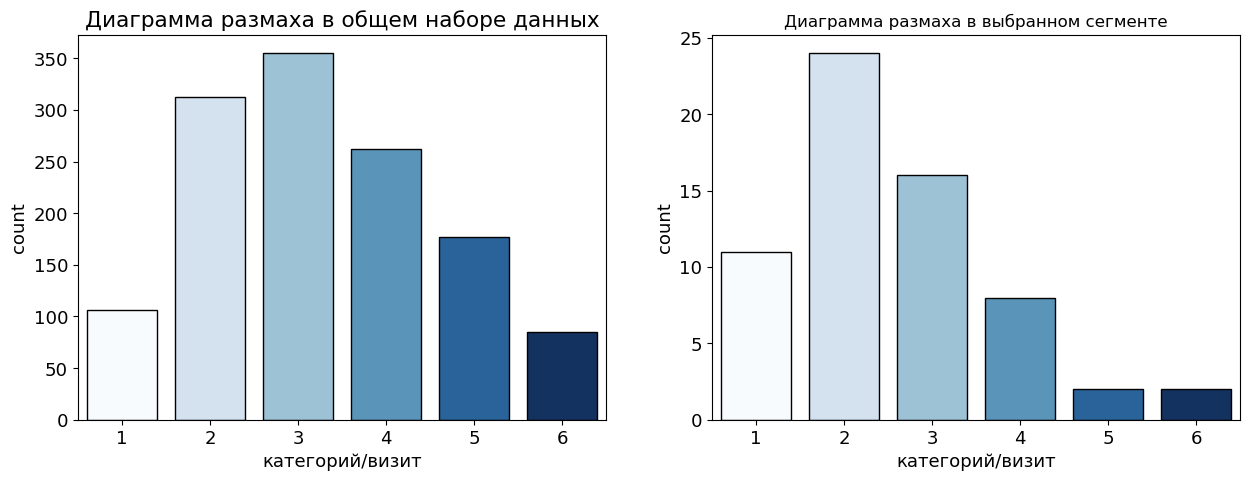

In [94]:
subplot_sr('категорий/визит')

Видно, что для выбранной группы покупателей среднее число просмотренных категорий товаров за один визит стало меньше. 

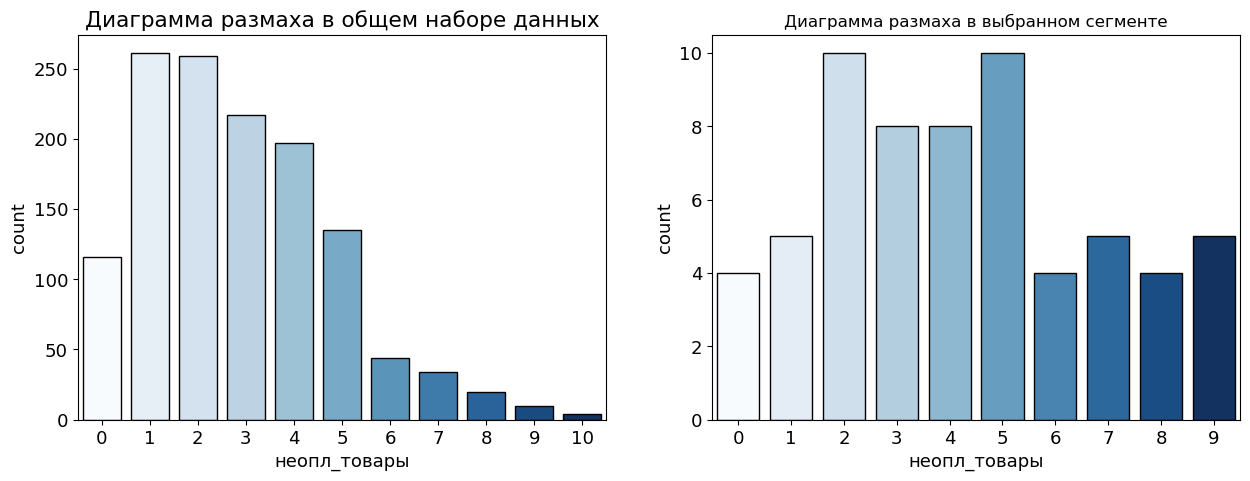

In [95]:
subplot_sr('неопл_товары')

Количество неоплаченных товаров возросло по сравнению с данными для всех пользователей. 

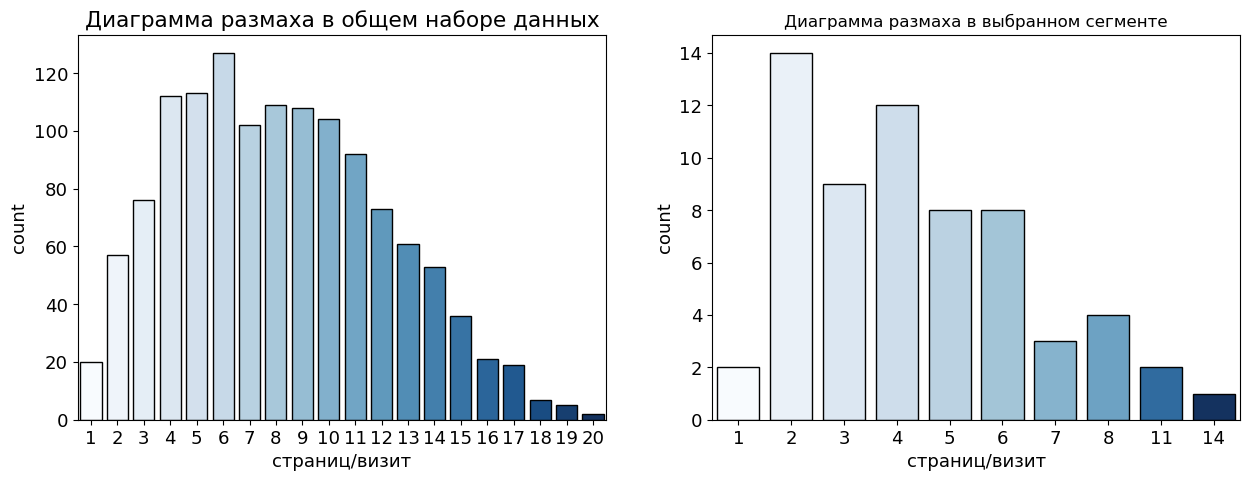

In [96]:
subplot_sr('страниц/визит')

Количество страниц, посещенных за один визит, значительно уменьшилось. Это в совокупности с уменьшением категорий товаров, просмотренных за один визит, может говорить о том, что данная группа пользователей лучше знают, какие товары их интересуют и предпочитает более целенаправленный шопинг.

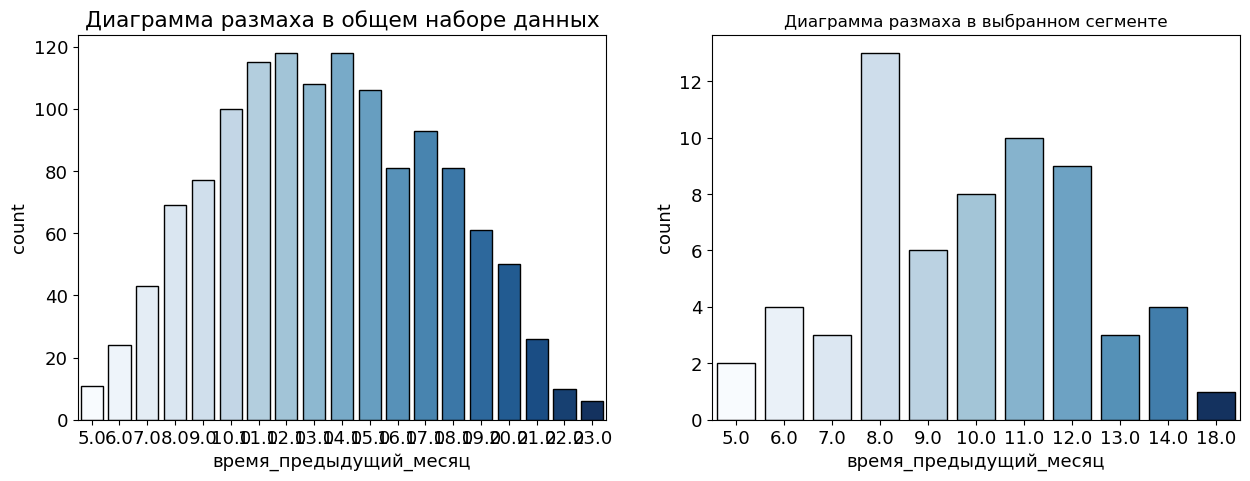

In [97]:
subplot_sr('время_предыдущий_месяц')

Время, проведенное на сайте в прошлом месяце, у выбранной группы тоже меньше.

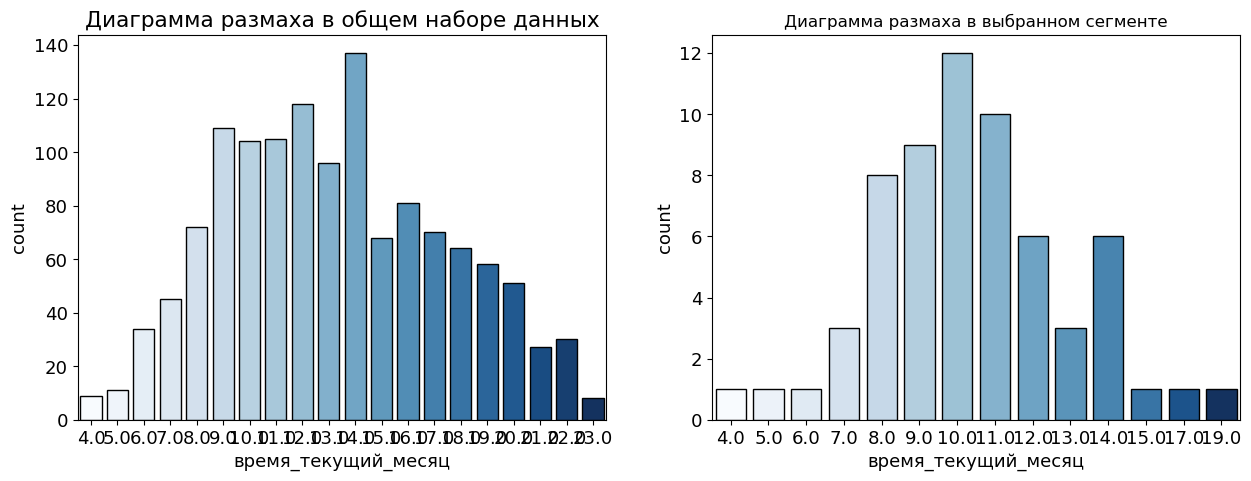

In [98]:
subplot_sr('время_текущий_месяц')

Время, проведенное на сайте в этом месяце, у выбранного сегмента покупателей также уменьшилось. Это согласуется с предыдущим распределениям времени в прошлом месяце и подтвержает вывод о том, что данная группа отдает предпочтение быстрому поиску нужных товаров. 

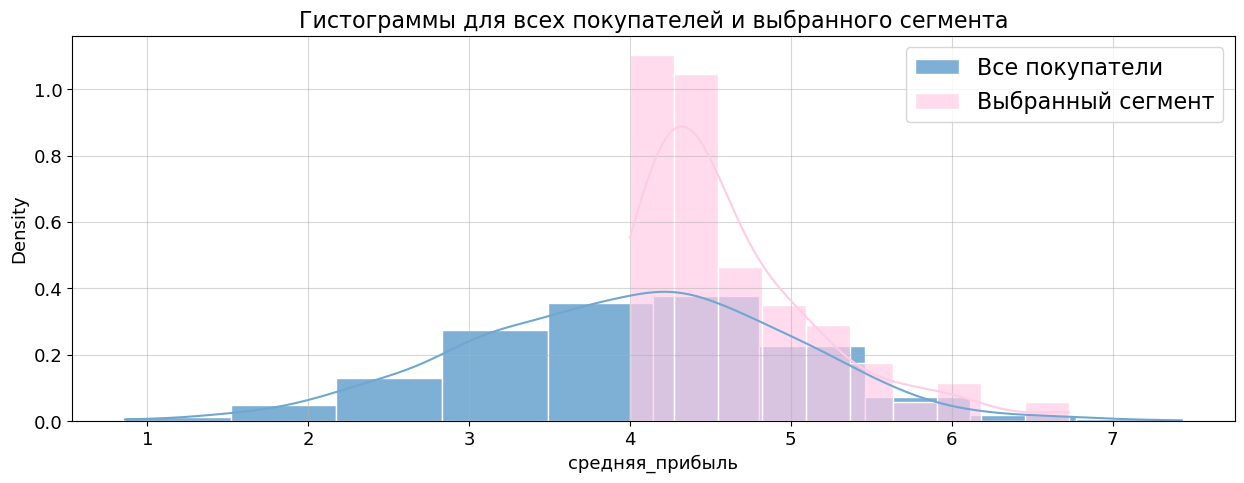

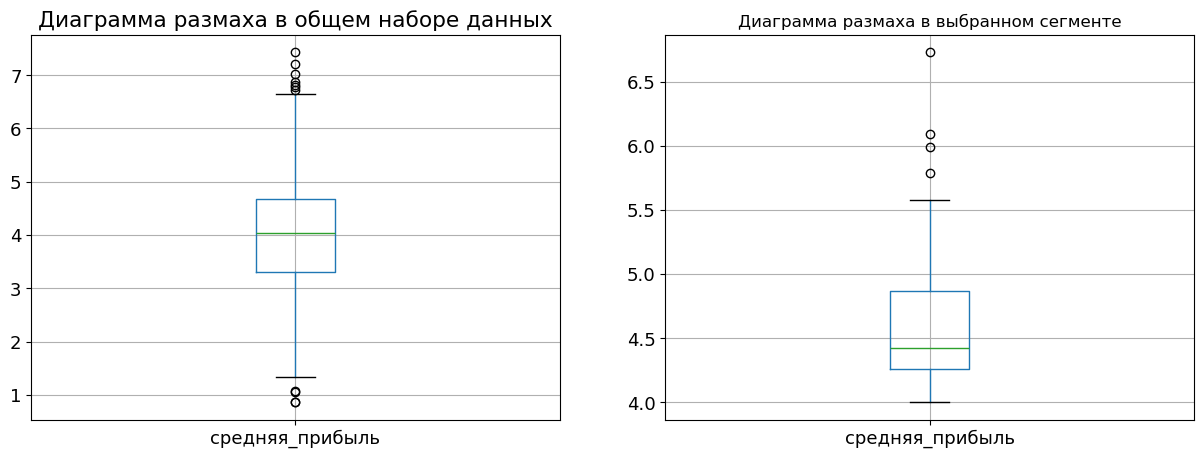

In [99]:
hist_sr('средняя_прибыль', 10)
boxplot_sr('средняя_прибыль')

Плотность распределения общей прибыли, полученной магазином от покупателя, для выбранной группы больше распредения данных для всех покупателей. Это объясняется тем, что мы выбирали в сегмент покупателей, приносящих наибольшую прибыль

**Выводы:** 
Для дополнительного исследования были выбраны пользователи с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности потому, что эта группа составляет значительную долю от всех покупателей и приносит примерно 10 процентов от все прибыли. С другой стороны, анализ важности признаков показал, что высокое значение признака доля акционных товаров повышает вероятность снижения покупательской активности. 

Анализ исследуемой группы показал, что такие пользователи тратят меньше времени на поиск товаров, рассматривают меньше категорий товаров и страниц сайта. Также этот сегмент пользователей чаще оставляет в корзине неоплаченные товары.

Для увеличения покупательской активности данного сегмента покупателей необходимо:
* добавить быстрые ссылки на популярные категории и товары по акциям
* разработать рекомендательные системы на основе предыдущих покупок
* разработать акции для товаров в корзине и внедрить систему напоминаний о товарах

## Общие выводы

**Цель работы**  заключалась в том, чтобы разработать эффективную систему персонализированных предложений постоянным клиентам интернет-магазина для увеличения их покупательской активности.

**Были изучены исходные данные:** загружено и проанализировано четыре датафрейма, в которых содержалась информация о коммуникации с клиентом, продуктовом и финансовом поведении покупателя, о поведении покупателя на сайте. 


**Была проведена предобработка данных:** изменены названия столбцов, данные были проверены на наличие дубликатов и пропусков, изменены типы данных там, где это было необходимо, устранены опечатки, категориальные данные приведены к единообразной записи


**Проведен исследовательский анализ данных**
1. Были отбраны клиенты с покупательской активностью не менее трёх месяцев
2. Покупательская активность снизилась у примерно 38 процентов пользователей
3. Анализ гистограммы среднемесячной доли акционных покупок за последние полгода выявил особую группу клиентов - совершающих покупки преимущественно по акциям
4. Средняя выручка от каждого покупателя около 5 тысяч у.е. При этом мы избавились от аномального высокого значения выручки и отбрали клиентов с покупательской активностью не менее трёх месяцев
5. Среднее значение времени которое покупатель проводит на сайте составляет около 13 минут
6. Средняя среднемесячная прибыль полученная от покупателя около 4 у.е.
  
  
**Проведен корреляционный анализ данных**
1. Наблюдается средняя связь между покупательной активностью и маркетинговыми коммуникациями за полгода, а также между покупателькой активностью и долей акционных товаров
2. Наблюдается средняя корреляция между покупательской активностью и средним временем проведенным покупателем на сайте, между покупателькой активностью и средним числом категорий, рассматриваемых пользователем за один визит  
3. Наблюдается сильная связь между покупателькой активностью и средним числом страниц, посещаемых пользователем за один визит  
4. Существенная мультиколлинеарность в модели отсутствует


**С использованием пайплайнов была найдена лучшая модель для предсказания вероятности снижения покупательской активности в ближайшие 3 месяца**
1. Были обучены 3 модели: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression
2. Для быстрого подбора гиперпараметров использовался рандомизированный поиск 
3. Для оценки качества моделей выбрана метрика ROC-AUC. Количество пользователей, сохраняющих прежний уровень покупательской активности, существенно превышает число клиентов, чья активность снизилась. Использование ROC-AUC позволяет корректно оценить качество моделей в условиях такого дисбаланса в данных.

*Лучшей моделью стала модель **DecisionTreeClassifier**, которая на тестовой выборке продемонстрировала высокое качество классификации с показателем ROC-AUC = 0.88.*

**Были проведен анализ важности признаков**
1. Было обнаружено отрицательное влияние (чем больше значение, тем выше вероятность сохранения покупательской активности) : время взаимодействия с сайтом и количество просмотренных страниц
2. Было обнаружено положительное влияние (чем больше значение, тем выше вероятность снижения активности): доля акционных товаров в покупках и количество неоплаченных товаров в корзине

**Была проведена сегментация покупателей**

Для дополнительного исследования были выбраны пользователи с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности. 
Для выбранной группы клиентов были выявлены следующие характерные особенности:
1. Пользователи проводят меньше времени на сайте
2. Пользователи просматривают минимальное количество категорий и страниц сайта
3. Более высокая доля неоплаченных товаров в корзине

**Для повышения эффективности взаимодействия с данным сегментом покупателей рекомендуются следующие меры:**

1. Оптимизация навигации:
* Внедрение системы быстрых ссылок на популярные категории и акционные предложения
* Разработка интуитивно понятного меню

2. Персонализация предложений:
* Внедрение рекомендательных систем
* Анализ истории покупок для формирования индивидуальных предложений

3. Работа с корзиной:
* Разработка специальных акций на товары в корзине
* Внедрение системы напоминаний
* Предложение альтернативных вариантов оплаты
* Упрощение процесса оформления заказа

Это позволит повысить вовлеченность пользователей и стимулировать рост их покупательской активности.